In [279]:
import pickle, glob

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import savgol_filter
from scipy import fftpack
from scipy import stats
from scipy.stats import multivariate_normal, norm
from scipy.ndimage.filters import gaussian_filter1d

import statsmodels.api as sm

from statsmodels.nonparametric.kernel_regression import KernelReg

from ast import literal_eval
from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter
from matplotlib.transforms import ScaledTranslation

def _load_file(path_to_files, zones_):

    file_ = pd.read_csv(path_to_files) 
    file_ = file_.rename(columns = {'LogS_': 'LogS', 
                                    'ES_': 'ES', 
                                    'VS_': 'VS', 
                                    'IS60_': 'IS60',
                                    'IS80_': 'IS80',
                                    'IS90_': 'IS90',
                                    'IS95_': 'IS95',
                                    'IS975_': 'IS975',
                                    'CI60_': 'CI60',
                                    'CI80_': 'CI80',
                                    'CI90_': 'CI90',
                                    'CI95_': 'CI95',
                                    'CI975_': 'CI975'})

    file_['RMSE'] = 0.

    N_zones = 1
    for zone in zones_:
        try:
            file_['RMSE'] += file_['RMSE_' + zone]
            N_zones += 1
        except:
            continue
        
    file_['RMSE'] = file_['RMSE']/N_zones
    file_['IS'] = file_['IS60'] + file_['IS80'] + file_['IS90'] + file_['IS95'] + file_['IS975']

    return file_

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
#mpl.rcParams['pdf.fonttype'] = 42

path_to_results = r'/Users/Guille/Desktop/caiso_power/results/journal_paper_w_sigma/'
path_to_images  = r'/Users/Guille/Desktop/caiso_power/images/'
path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'
path_to_aux     = r'/Users/Guille/Desktop/caiso_power/data/auxiliary/'
path_to_maps    = r'/Users/Guille/Desktop/caiso_power/data/maps/'
path_to_prc     = r'/Users/Guille/Desktop/caiso_power/data/processed/'

# Get California unlities and remove the ones that are not CAISO
_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_US    = gpd.read_file(path_to_maps + r"US/tl_2022_us_state.shp")
_CAISO = gpd.read_file(path_to_maps + r"CAISO/Balancing_Authority_Areas_in_CA.shp")
_CAISO = _CAISO.iloc[[1, 7]].to_crs("EPSG:4326")
W_ref_ = pickle.load(open(path_to_aux + r'ref_grid_0.125_(-125,-112)_(32,43).pkl', 'rb'))

resources_  = ['load', 'solar', 'wind']
dl_methods_ = ['BLR', 'RVM', 'GPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']

colors_1_ = ['#7d6674', '#006995', '#f48d64', '#09155a', '#e6cd94', '#0041a5']
colors_2_ = ['#126463', '#2CB7B5', '#CA8250']
colors_3_ = ['#1F390D', '#756A00', '#D8A581', '#92918B']

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_2904/3924275361.py:21: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


# Baseline Model Scores

In [209]:
def _dataframe(data_, index_, columns_, method, resource):
    df_             = pd.DataFrame(data_, index = index_, columns = columns_)
    df_['zone']     = df_.index
    df_['method']   = method
    df_['resource'] = resource
    df_             = df_.reset_index(drop = True)
    return df_

Persistence_ = np.array([[1432.425405, 0.191187], [1580.078333,  -6.230624], [299.133371, -0.699760]])
CAISO_       = np.array([[607.075561, 273.938328], [647.596172, 267.898981], [164.827576, 72.686353]])
Climatoloty_ = np.array([[1336.276707, 9.815701], [1541.191602, -4.939872], [289.481101, 1.025492]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'load')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'load')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'load')
ref_         = pd.concat([Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)

Persistence_ = np.array([[244.096715, -1.377402], [933.148375, -10.316115], [269.491617, -2.408633]])
CAISO_       = np.array([[255.950023, -95.328823], [649.992549, -258.398304], [209.531956, -65.376801]])
Climatoloty_ = np.array([[216.941925, -3.550991], [789.308296, -14.495869], [218.326947, -5.045071]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'solar')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'solar')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'solar')
ref_         = pd.concat([ref_, Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)

Persistence_ = np.array([[455.203618, -0.012404], [1170.880167, -4.723570]])
CAISO_       = np.array([[166.998352, -41.077674], [387.69634, -156.006200]])
Climatoloty_ = np.array([[354.895993, -1.108021], [946.000155, -12.270927]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'wind')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'wind')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'wind')
ref_         = pd.concat([ref_, Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)
print(ref_)

           RMSE         MBE  zone       method resource
0   1432.425405    0.191187  NP15  Presistence     load
1   1580.078333   -6.230624  SP15  Presistence     load
2    299.133371   -0.699760  ZP26  Presistence     load
3   1336.276707    9.815701  NP15  Climatology     load
4   1541.191602   -4.939872  SP15  Climatology     load
5    289.481101    1.025492  ZP26  Climatology     load
6    607.075561  273.938328  NP15        CAISO     load
7    647.596172  267.898981  SP15        CAISO     load
8    164.827576   72.686353  ZP26        CAISO     load
9    244.096715   -1.377402  NP15  Presistence    solar
10   933.148375  -10.316115  SP15  Presistence    solar
11   269.491617   -2.408633  ZP26  Presistence    solar
12   216.941925   -3.550991  NP15  Climatology    solar
13   789.308296  -14.495869  SP15  Climatology    solar
14   218.326947   -5.045071  ZP26  Climatology    solar
15   255.950023  -95.328823  NP15        CAISO    solar
16   649.992549 -258.398304  SP15        CAISO  

In [3]:
def _make_ref_plot(Scores_, zones_p_, score, resource, legend_labels_, legend_title, colors_, ndecimals = 0,
                                                                                              score_key = 'value',
                                                                                              ref_      = [],
                                                                                              xlabel    = '',
                                                                                              ylabel    = '', 
                                                                                              title     = '', 
                                                                                              suptitle  = '', 
                                                                                              letter    = '',
                                                                                              y_lim     = 0,
                                                                                              save      = False, 
                                                                                              legend    = False, 
                                                                                              filename  = 'noname.pdf'):
    
    methods_ = Scores_['method'].unique()
    zones_   = Scores_.loc[Scores_['resource'] == resource, 'zone'].unique()

    x_     = np.linspace(0, .333*len(methods_), len(methods_))
    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    refs_ = [1000., 500., 750.]
    ticks_ = []
    j = 0

    for zone in zones_p_:
        i = 0
        for method in methods_:
            idx_  = (Scores_['method'] == method) & (Scores_['zone'] == zone) & (Scores_['resource'] == resource)
            value = Scores_.loc[idx_, score_key].to_numpy()[0]
            
            if len(ref_) > 0:
                y = np.around((1. - value/ref_[j])*100, ndecimals)
                p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                             zorder = 9, 
                                             align  = 'center')
            else:
                y = np.around(value, ndecimals)
                p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                             zorder = 9, 
                                             align  = 'center')
            plt.bar_label(p, labels=[f'{x:,.0f}' for x in p.datavalues], size = 14)
           
            i += 1
        
        ticks_.append(x_.mean())
        x_ += offset
        j += 1
    idx_  = Scores_['resource'] == resource
    if y_lim == 0.:
        y_lim = Scores_.loc[idx_, score].max()
    plt.ylim(-y_lim*0.005, y_lim*1.125)

    plt.xticks(ticks_[:len(zones_p_)], zones_p_, fontsize = 10)
    
    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1.5, .825],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

#     ax.text(-1.3, y_lim*1.25, letter, fontsize = 20, 
#                                       weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    
    plt.show()

### Load Forecast Baseline

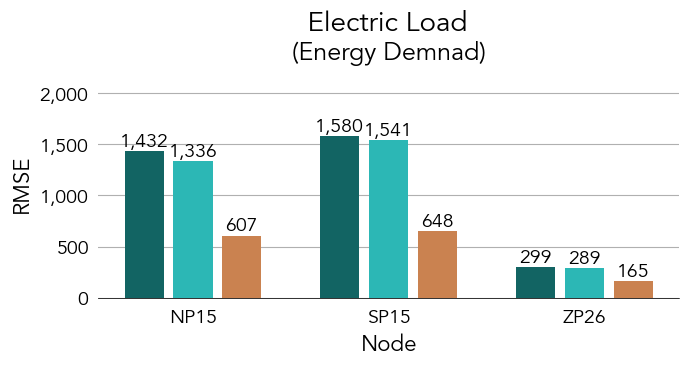

In [4]:
score    = 'RMSE'
resource = 'load'
y_lim    = 2000.
zones_   = ['NP15', 'SP15', 'ZP26']

_make_ref_plot(ref_, zones_, score, resource, colors_        = colors_2_, 
                                              ndecimals      = 0, 
                                              score_key      = score,
                                              legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                                              suptitle       = r'  Electric Load', 
                                              title          = r'(Energy Demnad)',
                                              xlabel         = r'Node',
                                              ylabel         = r'RMSE',
                                              legend_title   = r'Baseline',
                                              letter         = '',
                                              y_lim          = y_lim,
                                              save           = True, 
                                              legend         = False, 
                                              filename       = 'ref_{}_{}.png'.format(resource, score))


### Solar Forecast Baseline

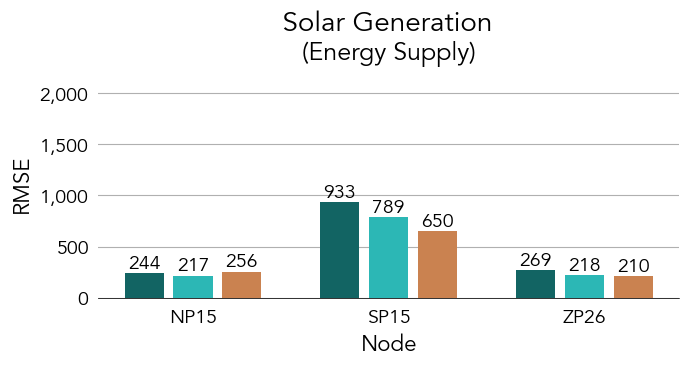

In [5]:
score    = 'RMSE'
resource = 'solar'
y_lim    = 2000.
zones_   = ['NP15', 'SP15', 'ZP26']

_make_ref_plot(ref_, zones_, score, resource, colors_        = colors_2_, 
                                              ndecimals      = 0, 
                                              score_key      = score,
                                              legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                                              suptitle       = r'  Solar Generation', 
                                              title          = r'(Energy Supply)',
                                              xlabel         = r'Node',
                                              ylabel         = r'RMSE',
                                              legend_title   = r'Baseline',
                                              letter         = '',
                                              y_lim          = y_lim,
                                              save           = True, 
                                              legend         = False, 
                                              filename       = 'ref_{}_{}.png'.format(resource, score))


### Wind Forecast Baseline

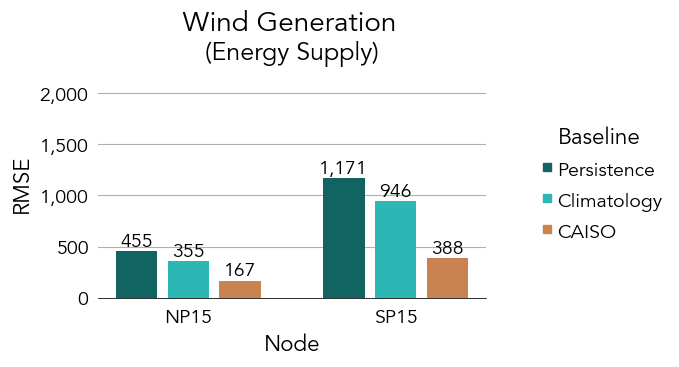

In [6]:
score    = 'RMSE'
resource = 'wind'
y_lim    = 2000.
zones_   = ['NP15', 'SP15']

_make_ref_plot(ref_, zones_, score, resource, colors_        = colors_2_, 
                                              ndecimals      = 0, 
                                              score_key      = score,
                                              legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                                              suptitle       = r' Wind Generation', 
                                              title          = r'(Energy Supply)',
                                              xlabel         = r'Node',
                                              ylabel         = r'RMSE',
                                              legend_title   = r'Baseline',
                                              letter         = '',
                                              y_lim          = y_lim,
                                              save           = True, 
                                              legend         = True, 
                                              filename       = 'ref_{}_{}.png'.format(resource, score))

# Machine Learning Model Selection

In [7]:
def _process_files(resources_, dl_methods_, sl_methods_, zones_, times_, scores_, N_tr):
    
    Scores_ = []

    for score in ['RMSE', 'LogS', 'ES', 'VS']:
        for resource in resources_:
            for dl_method in dl_methods_:
                for sl_method in sl_methods_:

                    file_name = r'{}/'.format(dl_method) + 'val-{}'.format(resource) + '-{}'.format(sl_method) + '-{}'.format(dl_method) + '.csv'
                    file_     = _load_file(path_to_results + file_name, zones_)
                    i_exp     = file_.loc[np.argmin(file_[score]), 'experiment']
                    #print(resource, dl_method, sl_method, i_exp)

                    file_name = r'{}/'.format(dl_method) + 'test-{}'.format(resource) + '-{}'.format(sl_method) + '-{}'.format(dl_method) + '.csv'
                    file_     = _load_file(path_to_results + file_name, zones_)
                    param     = file_.loc[file_['experiment'] == i_exp, 'parameters'].to_numpy()[0]
                    dim       = file_.loc[file_['experiment'] == i_exp, 'dimensions'].to_numpy()[0]

                    tr  = file_.loc[file_['experiment'] == i_exp, 'sparse_training_time'].to_numpy()[0] + file_.loc[file_['experiment'] == i_exp, 'dense_training_time'].to_numpy()[0]
                    ts  = file_.loc[file_['experiment'] == i_exp, 'testing_time'].to_numpy()[0] + file_.loc[file_['experiment'] == i_exp, 'prob_testing_time'].to_numpy()[0]
                    ts /= N_tr

                    meta_   = [resource, sl_method, dl_method, param, i_exp, dim, score, tr, ts]
                    values_ = [file_.loc[file_['experiment'] == i_exp, score].to_numpy()[0] for score in scores_]

                    Scores_.append(np.array(meta_ + values_))

    Scores_ = pd.DataFrame(np.stack(Scores_), columns = ['resource', 
                                                         'sparse_method', 
                                                         'dense_method', 
                                                         'parameters', 
                                                         'experiment', 
                                                         'dimensions', 
                                                         'score',
                                                         'training_time',
                                                         'testing_time'] + scores_)
    return Scores_

def _make_fs_plot(Scores_, ref_, zones_, resource, legend_labels_, legend_title, colors_, ndecimals = 0,
                                                                                          score     = 'RMSE',
                                                                                          xlabel    = '',
                                                                                          ylabel    = '', 
                                                                                          title     = '', 
                                                                                          letter    = '', 
                                                                                          suptitle  = '', 
                                                                                          save      = False, 
                                                                                          legend    = False, 
                                                                                          filename  = 'noname.pdf'):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()

    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(dense_methods_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    ticks_  = []
    values_ = []
    j = 0
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_  = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            
            idx_2_  = (ref_['method'] == 'CAISO') & (ref_['resource'] == resource) #& (ref_['zone'] == zone)
            
            
            value = 1. - np.min(float(Scores_.loc[idx_1_, score].to_numpy()[0]))/ref_.loc[idx_2_, score].to_numpy().mean()

            
            y = np.around(value*100, ndecimals)

            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 12, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(dense_methods_)], dense_methods_, fontsize = 10)
    
    y_min = -15.
    y_max = 12.5
    plt.ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

    ax.text(-1.25, y_max*1.1, letter, fontsize = 20, 
                                      weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename.format(resource, score), bbox_inches = 'tight',
                                                                       dpi         = 250)
    plt.show()

    
def _make_scores_plot(Scores_, zones_p_, resource, legend_labels_, legend_title, colors_, 
                      ndecimals       = 2, 
                      y_min           = 0.,
                      label_font_size = 10.,
                      score           = '', 
                      xlabel          = '',
                      ylabel          = '', 
                      title           = '', 
                      letter          = '', 
                      suptitle        = '', 
                      save            = False, 
                      legend          = False, 
                      filename        = 'noname.pdf'):
    

    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(dense_methods_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    ticks_  = []
    values_ = []
    j = 0
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_  = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            
            value = float(Scores_.loc[idx_1_, score].to_numpy()[0])
            values_.append(value)
            
            y = np.around(value, ndecimals)

            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [[f'{x:,.0f}', f'{x:,.1f}', f'{x:,.2f}', f'{x:,.3f}'][ndecimals] for x in p.datavalues], size = label_font_size)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(dense_methods_)], dense_methods_, fontsize = 10)
    
    y_max = np.max(np.array(values_))*1.15
    
    plt.ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .825],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(y_min, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.text(-1.25, y_max*1.1, letter, fontsize = 20, 
                                      weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename.format(resource, score), bbox_inches = 'tight',
                                                                       dpi         = 250)
    plt.show()
    

## Load Model Selection

In [8]:
resources_  = ['load', 'solar', 'wind']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['RMSE', 'LogS', 'ES', 'VS', 'IS']
bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

# val_scores_ = _load_val_scores(resources_, dl_methods_, sl_methods_, zones_, scores_)
# val_scores_.to_csv(path_to_mdls + 'prob_model_selection_{}.csv'.format(resources_[-1]), index = False)
# #print(val_scores_)


def _load_node_test_scores(resources_, zones_, sl_methods_, dl_methods_, scores_, bay_scores_):
    
    Scores_ = []
    for resource in resources_:
        for score in scores_:
            for sl_method in sl_methods_:
                for dl_method in dl_methods_:

                    filename = '{}-{}-{}-{}.pkl'.format(resource, sl_method, dl_method, score)
                    with open(path_to_mdls + filename, 'rb') as f:
                        _model = pickle.load(f)  
                    
                    for zone in _model['deterministic_scoring']['RMSE'].index:
                        meta_ = [resource, zone, sl_method, dl_method, score, _model['deterministic_scoring']['RMSE'][zone]]
                        Scores_.append(np.array(meta_))

    Scores_ = pd.DataFrame(np.stack(Scores_), columns = ['resource', 'zone', 'sparse_method', 'dense_method', 'score', 'RMSE'])

    return Scores_

zones_ = ['NP15', 'SP15', 'ZP26']
ts_scores_ = _load_node_test_scores(resources_, zones_, sl_methods_, dl_methods_, scores_, bay_scores_)
print(ts_scores_)

ts_scores_['RMSE'] = ts_scores_['RMSE'].astype(float)

    resource  zone sparse_method dense_method score                RMSE
0       load  NP15         lasso          BLR  RMSE   556.6719245870784
1       load  SP15         lasso          BLR  RMSE   659.3004153912085
2       load  ZP26         lasso          BLR  RMSE   162.5093584931035
3       load  NP15         lasso          RVM  RMSE    639.102493009816
4       load  SP15         lasso          RVM  RMSE   670.0701769638418
..       ...   ...           ...          ...   ...                 ...
635     wind  SP15   group_lasso          RVM    IS  416.94842830582684
636     wind  NP15   group_lasso          GPR    IS  171.39178961783793
637     wind  SP15   group_lasso          GPR    IS  406.48791209600506
638     wind  NP15   group_lasso        MTGPR    IS   170.2578569030889
639     wind  SP15   group_lasso        MTGPR    IS  400.20380351846126

[640 rows x 6 columns]


['NP15' 'SP15' 'ZP26']


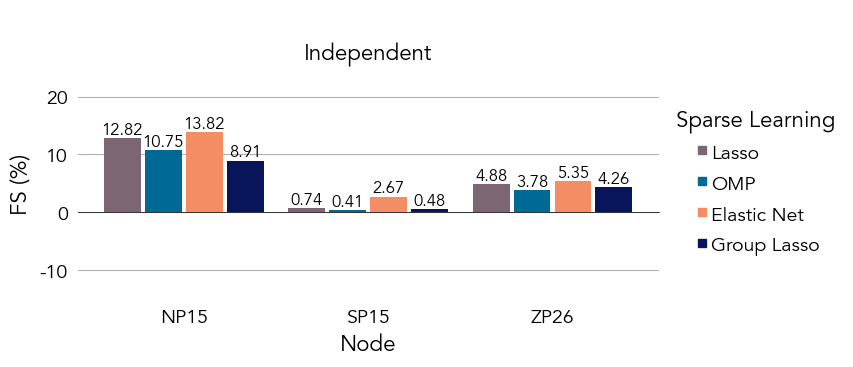

In [9]:
def _make_fs_node_plot(Scores_, ref_, zones_p_, legend_labels_, legend_title, colors_, dense_method,
                       score     = 'RMSE',
                       ndecimals = 0,
                       xlabel    = '',
                       ylabel    = '', 
                       title     = '', 
                       suptitle  = '', 
                       save      = False, 
                       legend    = False, 
                       filename  = 'noname.pdf'):
    
    #resources_      = Scores_['resource'].unique()
    sparse_methods_ = Scores_['sparse_method'].unique()
    zones_          = Scores_['zone'].unique()
    print(zones_)
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 16)

    ticks_  = []
    values_ = []
    j = 0

    for zone in zones_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['zone'] == zone) & (Scores_['dense_method'] == dense_method)  & (Scores_['score'] == score)
            idx_2_ = (ref_['method'] == 'CAISO') & (ref_['zone'] == zone)
            #y      = np.around(100*(1. -  Scores_.loc[idx_1_, 'RMSE'].sum()/ref_.loc[idx_2_, 'RMSE'].sum()), ndecimals)

            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['zone'] == zone) 

            y = np.around(100*(1. -  Scores_.loc[idx_1_].groupby(['resource', 'zone', 'sparse_method']).min().reset_index()['RMSE'].sum()/ref_.loc[idx_2_, 'RMSE'].sum()), ndecimals)
            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 12, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
    
    plt.xticks(ticks_[:len(zones_)], zones_, fontsize = 10)
    
    plt.ylim(-15, 25)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 300)
    plt.show()
    
zones_p_ = ['PG&E', 'SDGE', 'SCE']

_make_fs_node_plot(ts_scores_, ref_, zones_p_, 
                   colors_        = colors_1_, 
                   dense_method   = 'MTGPR',
                   ndecimals      = 2, 
                   legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                   xlabel         = 'Node',
                   ylabel         = 'FS (%)',
                   legend_title   = 'Sparse Learning',
                   save           = True, 
                   legend         = True, 
                   suptitle       = r' ', 
                   title          = r'Independent',
                   filename       = 'fs_node_RMSE.png')

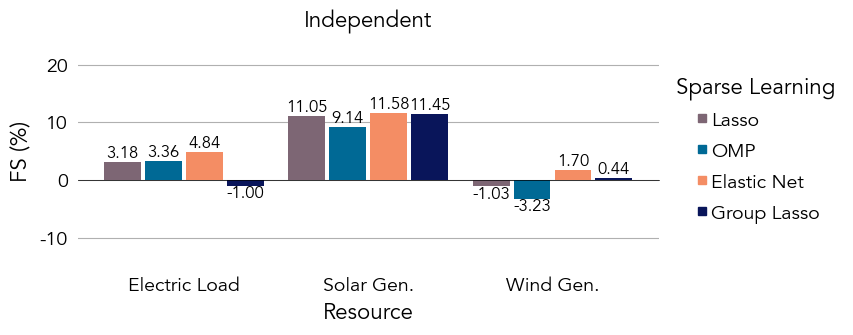

In [10]:
def _make_fs_resource_plot(Scores_, ref_, zones_p_, legend_labels_, legend_title, colors_, 
                           dense_method = 'BLR',
                           ndecimals    = 0,
                           score        = 'RMSE',
                           xlabel       = '',
                           ylabel       = '', 
                           title        = '', 
                           letter       = '', 
                           suptitle     = '', 
                           save         = False, 
                           legend       = False, 
                           filename     = 'noname.pdf'):
    
    resources_      = Scores_['resource'].unique()
    sparse_methods_ = Scores_['sparse_method'].unique()
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 16)

    ticks_  = []
    values_ = []
    j = 0

    for resource in resources_:
        i = 0
        for sparse_method in sparse_methods_:
            
            #idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score) & (Scores_['dense_method'] == dense_method)
            idx_2_ = (ref_['method'] == 'CAISO') & (ref_['resource'] == resource)
            #y = np.around(100*(1. -  Scores_.loc[idx_1_, score].sum()/ref_.loc[idx_2_, score].sum()), ndecimals)

            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['resource'] == resource) #& (Scores_['score'] == score)
            y = np.around(100*(1. -  Scores_.loc[idx_1_].groupby(['resource', 'zone', 'sparse_method']).min().reset_index()[score].sum()/ref_.loc[idx_2_, score].sum()), ndecimals)
            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 12, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(zones_p_)], zones_p_, fontsize = 10)
    
    plt.ylim(-15, 25)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 300)
    plt.show()
    
zones_p_ = ['Electric Load', 'Solar Gen.', 'Wind Gen.']

_make_fs_resource_plot(ts_scores_, ref_, zones_p_, 
                       dense_method   = 'GPR',
                       colors_        = colors_1_, 
                       score          = 'RMSE',
                       ndecimals      = 2, 
                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                       xlabel         = 'Resource',
                       ylabel         = 'FS (%)',
                       legend_title   = 'Sparse Learning',
                       save           = True, 
                       legend         = True, 
                       suptitle       = r'', 
                       title          = r'Independent',
                       filename       = 'fs_resource_RMSE.png')

### Load Models Forecasting Skill

In [11]:
def _make_fs_plot(Scores_, ref_, zones_, resource, legend_labels_, legend_title, colors_, ndecimals = 0,
                                                                                          score     = 'RMSE',
                                                                                          xlabel    = '',
                                                                                          ylabel    = '', 
                                                                                          title     = '', 
                                                                                          letter    = '', 
                                                                                          suptitle  = '', 
                                                                                          save      = False, 
                                                                                          legend    = False, 
                                                                                          filename  = 'noname.pdf'):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()

    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(dense_methods_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    ticks_  = []
    values_ = []
    j = 0
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            idx_2_ = (ref_['method'] == 'CAISO') & (ref_['resource'] == resource) #& (ref_['zone'] == zone)

            value = 1. - Scores_.loc[idx_1_, score]/ref_.loc[idx_2_, score].mean()
            
            #value = 1. - np.min(float(Scores_.loc[idx_1_, score].to_numpy()[0]))/ref_.loc[idx_2_, score].to_numpy().mean()

            
            y = np.around(value*100, ndecimals)

            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 12, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(dense_methods_)], dense_methods_, fontsize = 10)
    
    y_min = -15.
    y_max = 12.5
    plt.ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

    ax.text(-1.25, y_max*1.1, letter, fontsize = 20, 
                                      weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename.format(resource, score), bbox_inches = 'tight',
                                                                       dpi         = 250)
    plt.show()
    




In [226]:
def _load_val_scores(resources_, dl_methods_, sl_methods_, times_, scores_):
    
    Scores_ = []

    for score in ['RMSE', 'LogS', 'ES', 'VS', 'IS']:
        for resource in resources_:
            for dl_method in dl_methods_:
                for sl_method in sl_methods_:

                    file_name = r'{}/'.format(dl_method) + 'val-{}'.format(resource) + '-{}'.format(sl_method) + '-{}'.format(dl_method) + '.csv'
                    file_     = _load_file(path_to_results + file_name, zones_)
                    i_exp     = file_.loc[np.argmin(file_[score]), 'experiment']

                    parameters = file_.loc[file_['experiment'] == i_exp, 'parameters'].to_numpy()[0]
                    sigmas     = file_.loc[file_['experiment'] == i_exp, 'sigmas'].to_numpy()[0]

                    meta_   = [resource, sl_method, dl_method, i_exp, parameters, sigmas, score]
                    values_ = [file_.loc[file_['experiment'] == i_exp, score].to_numpy()[0] for score in scores_]

                    Scores_.append(np.array(meta_ + values_))

    Scores_ = pd.DataFrame(np.stack(Scores_), columns = ['resource', 
                                                         'sparse_method', 
                                                         'dense_method', 
                                                         'experiment',
                                                         'parameters', 
                                                         'sigmas', 
                                                         'score'] + scores_)
    return Scores_

resources_  = ['load']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['RMSE', 'LogS', 'ES', 'VS', 'IS']
bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

val_scores_ = _load_val_scores(resources_, dl_methods_, sl_methods_, zones_, scores_)
#val_scores_.to_csv(path_to_mdls + 'prob_model_selection_{}.csv'.format(resources_[-1]), index = False)
#print(val_scores_)

In [573]:
def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

def _IS(Y_, M_, S2_, z, alpha):
    
    # Interval Score
    def __IS(y_, alpha, lower_, upper_):
        score_  = (upper_ - lower_)
        score_ += (2./alpha)*(lower_ - y_) * (1*(y_ < lower_))
        score_ += (2./alpha)*(y_ - upper_) * (1*(y_ > upper_))
        return score_
    # 95% CI: z = 1.96; alpha = 0.05
    # 90% CI: z = 1.645; alpha = 0.1
    N_observation, N_horizons = M_.shape
    # Y_     = np.concatenate([Y_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # M_     = np.concatenate([M_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # S2_    = np.concatenate([S2_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    score_ = np.zeros((N_observation,))
    for n in range(N_observation):
        score_[n] = __IS(Y_[n, :], alpha, lower_ = M_[n, :] - z*np.sqrt(S2_[n, :]),
                                          upper_ = M_[n, :] + z*np.sqrt(S2_[n, :])).sum()
    return score_

def _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, bay_scores_):
    
    Scores_ = []
    for resource in resources_:
        for score in scores_:
            for sl_method in sl_methods_:
                for dl_method in dl_methods_:
                    meta_ = [resource, sl_method, dl_method, score]

                    filename = '{}-{}-{}-{}.pkl'.format(resource, sl_method, dl_method, score)
                    with open(path_to_mdls + filename, 'rb') as f:
                        _model = pickle.load(f)  
                    
                    Y_      = np.sum(_model['targets'], axis = 1)
                    Y_iso_  = np.sum(_model['caiso'], axis = 1)
                    Y_mean_ = np.sum(_model['mean'], axis = 1)
                    Y_var_  = np.sum(_model['variance'], axis = 1)
                    
                    N_samples, N_tasks, N_horizons = _model['mean'].shape
                    Z = N_samples*N_tasks*N_horizons
                
                    IS975 = _IS(Y_, Y_mean_, Y_var_, z = 2.243, alpha = 0.025).sum()/Z
                    IS95  = _IS(Y_, Y_mean_, Y_var_, z = 1.959, alpha = 0.05).sum()/Z
                    IS90  = _IS(Y_, Y_mean_, Y_var_, z = 1.645, alpha = 0.1).sum()/Z
                    IS80  = _IS(Y_, Y_mean_, Y_var_, z = 1.282, alpha = 0.2).sum()/Z
                    IS60  = _IS(Y_, Y_mean_, Y_var_, z = 0.842, alpha = 0.4).sum()/Z
                    IS    =  IS975 + IS95 + IS90 + IS80 + IS60
                    RMSE    = _RMSE(Y_, Y_mean_).mean()
                    FS      = 100*(1. - _RMSE(Y_, Y_mean_).sum()/_RMSE(Y_, Y_iso_).sum())
                    values_ = [RMSE, FS, IS, IS60, IS80, IS90, IS95, IS975]
                    for bay_score in bay_scores_:
                        values_.append(float(_model['bayesian_scoring'][bay_score].to_numpy()[0]))
                    
                    Scores_.append(np.array(meta_ + values_))

    return pd.DataFrame(np.stack(Scores_), columns = ['resource', 'sparse_method', 'dense_method', 'score', 'RMSE', 'FS', 'IS', 'IS60','IS80','IS90','IS95', 'IS975'] + bay_scores_)

resources_  = ['load', 'solar', 'wind']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['RMSE', 'LogS', 'ES', 'VS', 'IS']
bay_scores_ = ['LogS', 'ES', 'VS']

ts_scores_ = _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, bay_scores_)
print(ts_scores_)
ts_scores_['RMSE']  = ts_scores_['RMSE'].astype(float)
ts_scores_['LogS']  = ts_scores_['LogS'].astype(float)
ts_scores_['ES']    = ts_scores_['ES'].astype(float)
ts_scores_['VS']    = ts_scores_['VS'].astype(float)
ts_scores_['FS']    = ts_scores_['FS'].astype(float)
ts_scores_['IS']    = ts_scores_['IS'].astype(float)
ts_scores_['IS975'] = ts_scores_['IS975'].astype(float)
ts_scores_['IS95']  = ts_scores_['IS95'].astype(float)
ts_scores_['IS90']  = ts_scores_['IS90'].astype(float)
ts_scores_['IS80']  = ts_scores_['IS80'].astype(float)
ts_scores_['IS60']  = ts_scores_['IS60'].astype(float)

# for resource in ts_scores_['resource'].unique():
#     for score in ['RMSE']:
#         idx_ = (ts_scores_['score'] == score) & (ts_scores_['resource'] == resource)
#         print(ts_scores_.loc[ts_scores_[score] == ts_scores_.loc[idx_, score].min()].T)

    resource sparse_method dense_method score                RMSE  \
0       load         lasso          BLR  RMSE  1104.1237573887158   
1       load         lasso          RVM  RMSE  1113.8058131442717   
2       load         lasso          GPR  RMSE  1129.3424663388137   
3       load         lasso        MTGPR  RMSE  1217.6469781635417   
4       load           OMP          BLR  RMSE    1130.85347928653   
..       ...           ...          ...   ...                 ...   
235     wind   elastic_net        MTGPR    IS  420.43205818464077   
236     wind   group_lasso          BLR    IS   449.0795743906515   
237     wind   group_lasso          RVM    IS     456.51642773914   
238     wind   group_lasso          GPR    IS   442.5329506563421   
239     wind   group_lasso        MTGPR    IS    432.507060684339   

                        FS                  IS                IS60  \
0        2.355604528568489   8163.841822155597   1028.260404311825   
1       1.4993613086890178   80

In [558]:
# resources_  = ['load', 'solar', 'wind']
# sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
# dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
# zones_      = ['NP15', 'SP15', 'ZP26']
# scores_     = ['RMSE', 'LogS', 'ES', 'VS', 'IS']
# bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

# ts_scores_l_ = _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, bay_scores_)

# ts_scores_l_['RMSE'] = ts_scores_l_['RMSE'].astype(float)
# ts_scores_l_['LogS'] = ts_scores_l_['LogS'].astype(float)
# ts_scores_l_['ES']   = ts_scores_l_['ES'].astype(float)
# ts_scores_l_['VS']   = ts_scores_l_['VS'].astype(float)
# ts_scores_l_['IS']   = ts_scores_l_['IS'].astype(float)

# ts_scores_l_['ensamle'] = 0.

# for resource in ts_scores_l_['resource'].unique():
#     for score in ts_scores_l_['score'].unique():
#         idx_ = (ts_scores_l_['score'] == score) & (ts_scores_l_['resource'] == resource)
#         ts_scores_l_.loc[idx_, 'ensamle'] += ts_scores_l_.loc[idx_, 'LogS']/ts_scores_l_.loc[idx_, 'LogS'].max()
#         ts_scores_l_.loc[idx_, 'ensamle'] += ts_scores_l_.loc[idx_, 'ES']/ts_scores_l_.loc[idx_, 'ES'].max()
#         ts_scores_l_.loc[idx_, 'ensamle'] += ts_scores_l_.loc[idx_, 'VS']/ts_scores_l_.loc[idx_, 'VS'].max()
#         ts_scores_l_.loc[idx_, 'ensamle'] += ts_scores_l_.loc[idx_, 'IS']/ts_scores_l_.loc[idx_, 'IS'].max()

# for resource in ts_scores_l_['resource'].unique():
#     for score in ['LogS', 'ES', 'VS', 'IS']:
#         idx_ = (ts_scores_l_['score'] == score) & (ts_scores_l_['resource'] == resource)
#         print(ts_scores_l_.loc[ts_scores_l_['ensamle'] == ts_scores_l_.loc[idx_, 'ensamle'].min()].T)

In [559]:
# resources_  = ['load', 'solar', 'wind']
# sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
# dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
# zones_      = ['NP15', 'SP15', 'ZP26']
# scores_     = ['LogS', 'ES', 'VS']
# bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

# ts_scores_l_ = _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, bay_scores_)

# ts_scores_l_['RMSE'] = ts_scores_l_['RMSE'].astype(float)
# ts_scores_l_['LogS'] = ts_scores_l_['LogS'].astype(float)
# ts_scores_l_['ES']   = ts_scores_l_['ES'].astype(float)
# ts_scores_l_['VS']   = ts_scores_l_['VS'].astype(float)
# ts_scores_l_['IS']   = ts_scores_l_['IS'].astype(float)

# ts_scores_l_['ensamle'] = 0.

# for resource in ts_scores_l_['resource'].unique():
#     for score in ts_scores_l_['score'].unique():
#         idx_ = (ts_scores_l_['score'] == score) & (ts_scores_l_['resource'] == resource)
#         #ts_scores_l_.loc[idx_, 'ensamle'] += (ts_scores_l_.loc[idx_, 'RMSE'] - ts_scores_l_.loc[idx_, 'RMSE'].min())/(ts_scores_l_.loc[idx_, 'RMSE'].max() - ts_scores_l_.loc[idx_, 'RMSE'].min())
#         ts_scores_l_.loc[idx_, 'ensamle'] += (ts_scores_l_.loc[idx_, 'LogS'] - ts_scores_l_.loc[idx_, 'LogS'].mean())/ts_scores_l_.loc[idx_, 'LogS'].std()
#         ts_scores_l_.loc[idx_, 'ensamle'] += (ts_scores_l_.loc[idx_, 'ES'] - ts_scores_l_.loc[idx_, 'ES'].mean())/ts_scores_l_.loc[idx_, 'ES'].std()
#         ts_scores_l_.loc[idx_, 'ensamle'] += (ts_scores_l_.loc[idx_, 'VS'] - ts_scores_l_.loc[idx_, 'VS'].mean())/ts_scores_l_.loc[idx_, 'VS'].std()
#         ts_scores_l_.loc[idx_, 'ensamle'] += ((ts_scores_l_.loc[idx_, 'IS'] - ts_scores_l_.loc[idx_, 'IS'].mean())**2)/ts_scores_l_.loc[idx_,'IS'].std()**2

# for resource in ts_scores_l_['resource'].unique():
#     for score in ts_scores_l_['score'].unique():

#         idx_ = (ts_scores_l_['resource'] == resource) & (ts_scores_l_['score'] == score)
#         print(ts_scores_l_.loc[ts_scores_l_['ensamle'] == ts_scores_l_.loc[idx_, 'ensamle'].min()].T)

In [560]:
# _make_fs_plot(ts_scores_l_, ref_, zones_, resource       = 'load', 
#                                           colors_        = colors_1_, 
#                                           score          = 'RMSE',
#                                           ndecimals      = 2, 
#                                           legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                           xlabel         = 'Bayesian Learning',
#                                           ylabel         = 'FS (%)',
#                                           legend_title   = 'Sparse Learning',
#                                           save           = True, 
#                                           legend         = False, 
#                                           suptitle       = r'  Electric Load', 
#                                           title          = r'(Energy Demand)',
#                                           filename       = 'fs_{}_{}.png')

# Load Models Interval Scores

In [493]:
print(ts_scores_.loc[ts_scores_['IS'] == ts_scores_['IS'].min()])

   resource sparse_method dense_method score        RMSE                  IS  \
96    solar         lasso          BLR  LogS  331.728643  1026.1070375669399   

                    FS      LogS        ES          VS        IS60  \
96  14.202457383944934  5.847523  32.11559  2222.18125  659.333493   

          IS80         IS90         IS95        IS975  
96  835.800458  1017.362986  1206.048539  1411.989711  


### Load Models Scoring Rules - Bar Plot

In [562]:
# _make_scores_plot(ts_scores_, zones_, resource       = 'load', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 2, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'ES',
#                                       xlabel         = 'Bayesian Learning',
#                                       ylabel         = 'ES',
#                                       legend_title   = 'Sparse Learning',
#                                       save           = True, 
#                                       legend         = True, 
#                                       filename       = 'score_bar_{}_{}.png')

# _make_scores_plot(ts_scores_, zones_, resource       = 'load', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 0, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'VS',
#                                       xlabel         = 'Bayesian Learning',
#                                       ylabel         = 'VS',
#                                       legend_title   = 'Sparse Learning',
#                                       save           = True, 
#                                       legend         = False, 
#                                       filename       = 'score_bar_{}_{}.png')

# _make_scores_plot(ts_scores_, zones_, resource       = 'load', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 3, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'LogS',
#                                       xlabel         = 'Bayesian Learning',
#                                       ylabel         = 'LogS',
#                                       legend_title   = 'Sparse Learning',
#                                       save           = True, 
#                                       legend         = False, 
#                                       filename       = 'score_bar_{}_{}.png')

### Load Models Scoring Rules - Box Plot

In [35]:
def _load_sample_scores(resources_, sl_models_, dl_models_, scores_, criteria_):
    _results = {}
    for resource in resources_:
        _results[resource] = {}

        for criteria in criteria_:
            _results[resource][criteria] = {}

            for sl_model in sl_models_:
                _results[resource][criteria][sl_model] = {}

                for dl_model in dl_models_:
                    _results[resource][criteria][sl_model][dl_model] = {}
                    filename = '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, criteria)

                    with open(path_to_mdls + filename, 'rb') as f:
                        _model = pickle.load(f)   
                        
                    for score in scores_:
                        _results[resource][criteria][sl_model][dl_model][score] = _model['bayesian_scoring_all'][score].to_numpy()

    return _results


_results = _load_sample_scores(resources_ = ['load', 'solar', 'wind'], 
                               sl_models_ = sl_methods_, 
                               dl_models_ = dl_methods_, 
                               scores_    = ['ES', 'LogS', 'VS'],
                               criteria_  = ['ES', 'LogS', 'VS'])

In [225]:
def _plot_box(ax, _results, sl_models_, dl_models_, resource, score, criteria, colors_, 
              units        = 1.,
              y_min        = 0., 
              y_max        = 0., 
              legend_labels_ = [],
              suptitle     = '', 
              title        = '', 
              legend_title = '', 
              letter       = '',
              legend       = False, 
              save         = False, 
              path         = '',
              filename     = 'unname.pdf'):

    width  = 0.15
    offset = 1.

    x_ = np.linspace(0, width*len(sl_models_), len(sl_models_))


    # fig = plt.figure(figsize = (3.5, 3.))
    # ax  = plt.subplot(111)

    ticks_ = []
    for dl_model in dl_models_:

        i = 0
        for sl_model in sl_models_:

            df_      = pd.DataFrame()
            df_['y'] = _results[resource][criteria][sl_model][dl_model][score]
            df_['x'] = x_[i]

            _box = ax.boxplot(df_['y']/units, positions    = [x_[i]], 
                                              showmeans    = True, 
                                              showfliers   = False, 
                                              patch_artist = True, 
                                              zorder       = 10)
            
            # change outline color
            _box['boxes'][0].set(color = colors_[i], linewidth = .5, edgecolor = 'k', facecolor = colors_[i], alpha = 1.)
            _box['medians'][0].set(color = 'lightgray', zorder = 10)
            _box['means'][0].set(marker = "o", markersize = 5., markeredgewidth = .75, markeredgecolor = 'k', markerfacecolor = 'white')
            #_box['fliers'][0].set(marker = "o", markersize = 1.25, markeredgewidth = .5,  markeredgecolor = 'k', markerfacecolor = 'None', alpha = .5)
            _box['whiskers'][0].set(linewidth = .5)
            _box['whiskers'][1].set(linewidth = .5)
            _box['caps'][0].set(linewidth = .5)
            _box['caps'][1].set(linewidth = .5)

            i +=1 

        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel(score, fontsize = 14)
    # plt.xlabel(xlabel, fontsize = 16)

    ax.set_xticks(ticks_[:len(dl_models_)], dl_models_, fontsize = 14)

    ax.set_ylim(y_min, y_max)
    #plt.xlim(-0.25, 2.75)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 14}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [0.35, .65],
                            #loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
        


    
    ax.grid(axis      = 'y', 
             alpha     = .5, 
             linestyle = '-')
    


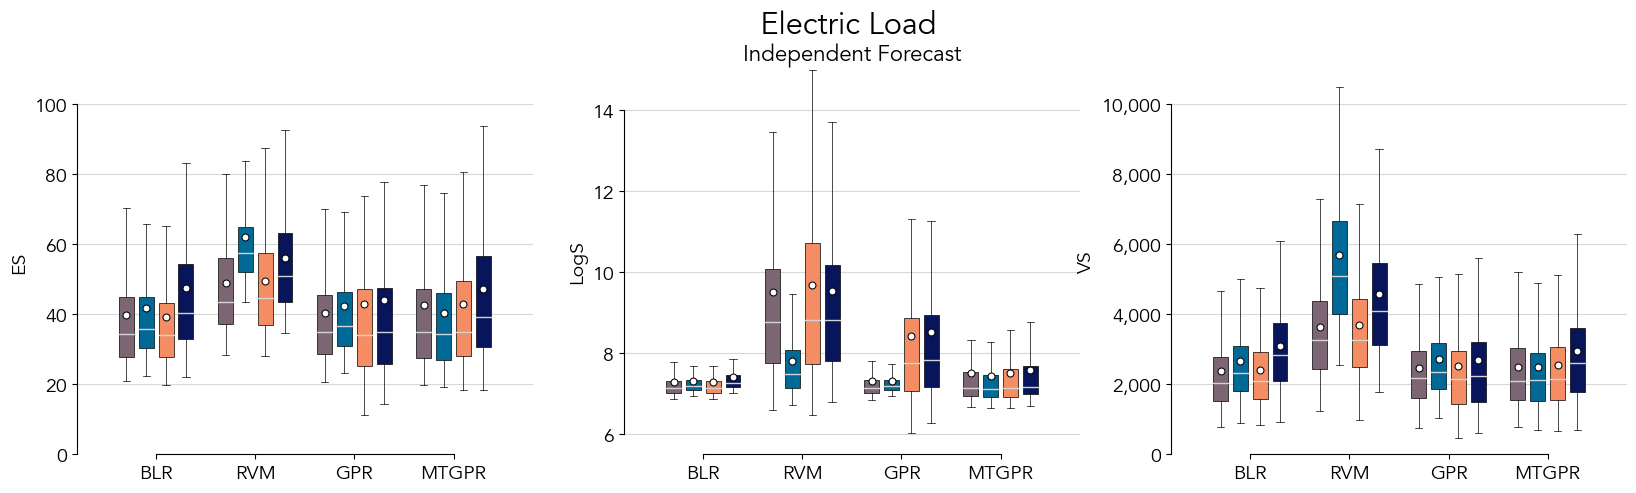

In [226]:
criteria = 'ES'
resource = 'load'

fig, (_ax1, _ax2, _ax3) = plt.subplots(1, 3, figsize = (20, 5))

_plot_box(_ax1, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'ES', 
                                                    y_min          = 0, 
                                                    y_max          = 110, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

_ax2.set_title('Independent Forecast', fontsize = 16, y = 1)

_plot_box(_ax2, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'LogS', 
                                                    y_min          = 5.5, 
                                                    y_max          = 15, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

_plot_box(_ax3, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'VS', 
                                                    y_min          = 0, 
                                                    y_max          = 11000, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

sns.despine(trim   = True, 
            offset = 0)

plt.suptitle('     Electric Load', fontsize = 22, y = 1)

plt.savefig(path_to_images + f'boxplot_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                   dpi         = 300)


plt.show()

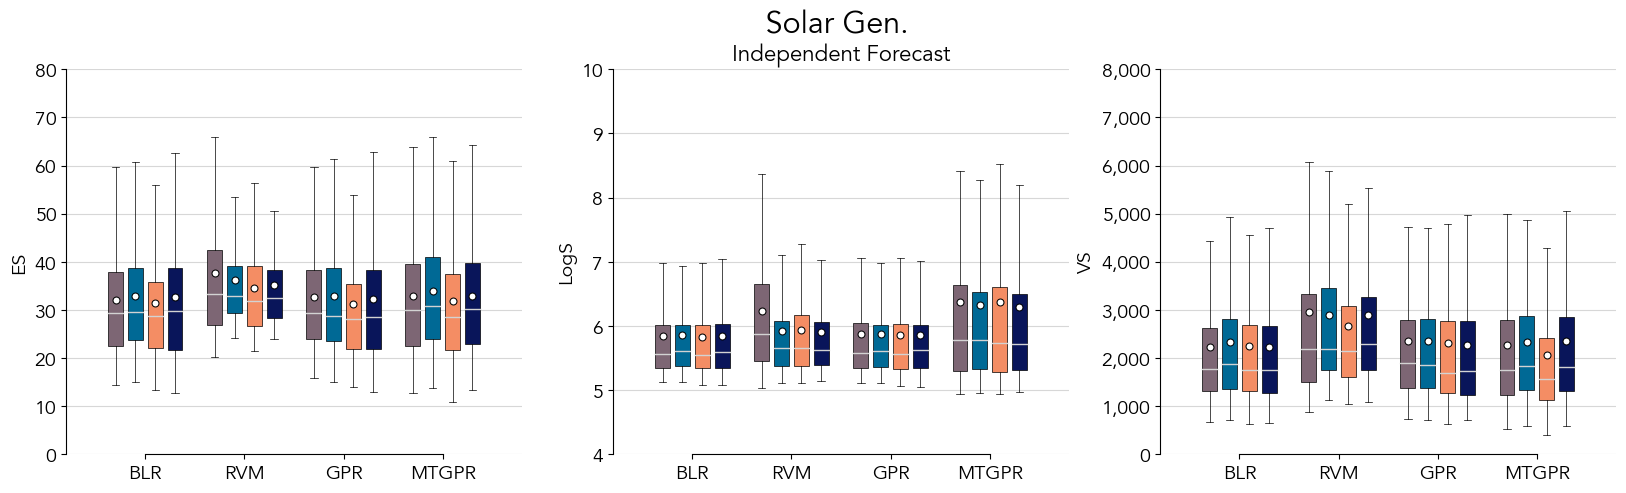

In [228]:
criteria = 'LogS'
resource = 'solar'

fig, (_ax1, _ax2, _ax3) = plt.subplots(1, 3, figsize = (20, 5))

_plot_box(_ax1, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'ES', 
                                                    y_min          = 0, 
                                                    y_max          = 80, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

_ax2.set_title('Independent Forecast', fontsize = 16, y = 1)

_plot_box(_ax2, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'LogS', 
                                                    y_min          = 4, 
                                                    y_max          = 10, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

_plot_box(_ax3, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'VS', 
                                                    y_min          = 0, 
                                                    y_max          = 8000, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

sns.despine(trim   = True, 
            offset = 0)

plt.suptitle('     Solar Gen.', fontsize = 22, y = 1)

plt.savefig(path_to_images + f'boxplot_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                   dpi         = 300)


plt.show()

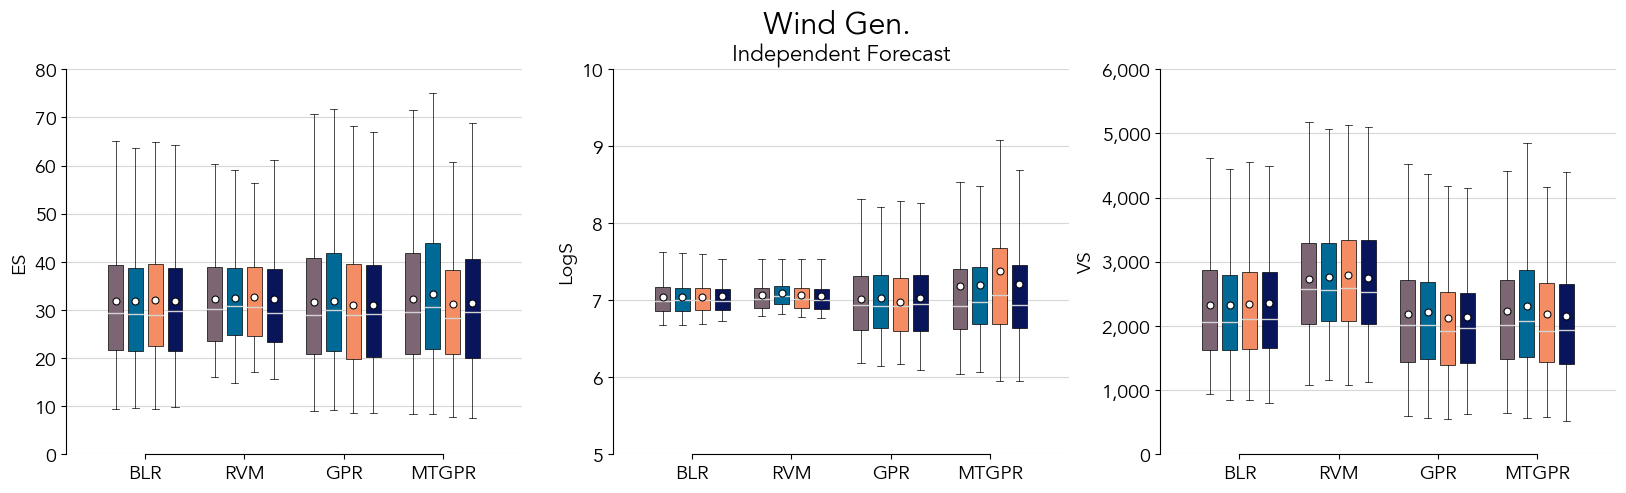

In [229]:
criteria = 'VS'
resource = 'wind'

fig, (_ax1, _ax2, _ax3) = plt.subplots(1, 3, figsize = (20, 5))

_plot_box(_ax1, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'ES', 
                                                    y_min          = 0, 
                                                    y_max          = 80, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

_ax2.set_title('Independent Forecast', fontsize = 16, y = 1)

_plot_box(_ax2, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'LogS', 
                                                    y_min          = 5., 
                                                    y_max          = 10, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

_plot_box(_ax3, _results, sl_methods_, dl_methods_, resource       = resource, 
                                                    criteria       = criteria,
                                                    score          = 'VS', 
                                                    y_min          = 0, 
                                                    y_max          = 6000, 
                                                    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                    colors_        = colors_1_,
                                                    legend_title   = 'Sparse Learning', 
                                                    legend         = False, 
                                                    save           = True)

sns.despine(trim   = True, 
            offset = 0)

plt.suptitle('     Wind Gen.', fontsize = 22, y = 1)

plt.savefig(path_to_images + f'boxplot_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                   dpi         = 300)


plt.show()

In [208]:
# _plot_box(_results, sl_methods_, dl_methods_, resource       = 'load', 
#                                               score          = 'ES', 
#                                               units          = 1,
#                                               y_min          = 0, 
#                                               y_max          = 25000, 
#                                               legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
#                                               colors_        = colors_1_,
#                                               legend         = True, 
#                                               legend_title   = 'Sparse Learning', 
#                                               save           = True,
#                                               path           = path_to_images, 
#                                               filename       = 'scores_box_load_VS.png')

# _plot_box(_results, sl_methods_, dl_methods_, resource       = 'load', 
#                                               score          = 'LogS', 
#                                               units          = 1,
#                                               y_min          = 0, 
#                                               y_max          = 25000, 
#                                               legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
#                                               colors_        = colors_1_,
#                                               legend         = True, 
#                                               legend_title   = 'Sparse Learning', 
#                                               save           = True,
#                                               path           = path_to_images, 
#                                               filename       = 'scores_box_load_VS.png')

# _plot_box(_results, sl_methods_, dl_methods_, resource       = 'load', 
#                                               score          = 'VS', 
#                                               units          = 1,
#                                               y_min          = 0, 
#                                               y_max          = 25000, 
#                                               legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
#                                               colors_        = colors_1_,
#                                               legend         = True, 
#                                               legend_title   = 'Sparse Learning', 
#                                               save           = True,
#                                               path           = path_to_images, 
#                                               filename       = 'scores_box_load_VS.png')

In [581]:
def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

from scipy.stats import norm, multivariate_normal

# Energy Score across time
def _ES(Y_, Y_hat_):

    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape

    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)

    for n in range(N_observation):
        Y_p_   = np.tile(Y_[n, :], (N_scen, 1)).T
        frac1_ = np.sqrt(np.diag((Y_hat_[n, :, :] - Y_p_).T @ (Y_hat_[n, :, :] - Y_p_)))
        frac2_ = 0
        for m in range(N_scen):
            frac2_ += np.sqrt(np.sum((Y_hat_[n, :, :].T - Y_hat_[n, :, m])**2, axis = 1))
        score_[n] = (np.sum(frac1_)/N_scen) - (np.sum(frac2_)/(2*(N_scen**2)))
    return score_

# Variogram Score computed across temporal dimensions
def _VS(Y_, Y_hat_, p = .5):
    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape
    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    for n in range(N_observation):
        frac1_ = np.absolute(np.subtract.outer(Y_[n, ], Y_[n, :]))**p
        frac2_ = np.zeros((N_horizons*N_tasks, N_horizons*N_tasks))
        for m in range(N_scen):
            frac2_ += np.absolute(np.subtract.outer(Y_hat_[n, :, m], Y_hat_[n, :, m]))**p
        score_[n] = np.sum((frac1_ - (frac2_/N_scen))**2)
    return score_

def _IS(Y_, M_, S2_, z, alpha):
    
    # Interval Score
    def __IS(y_, alpha, lower_, upper_):
        score_  = (upper_ - lower_)
        score_ += (2./alpha)*(lower_ - y_) * (1*(y_ < lower_))
        score_ += (2./alpha)*(y_ - upper_) * (1*(y_ > upper_))
        return score_
    # 95% CI: z = 1.96; alpha = 0.05
    # 90% CI: z = 1.645; alpha = 0.1
    N_observation, N_horizons = M_.shape
    # Y_     = np.concatenate([Y_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # M_     = np.concatenate([M_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # S2_    = np.concatenate([S2_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    score_ = np.zeros((N_observation,))
    for n in range(N_observation):
        score_[n] = __IS(Y_[n, :], alpha, lower_ = M_[n, :] - z*np.sqrt(S2_[n, :]),
                                          upper_ = M_[n, :] + z*np.sqrt(S2_[n, :])).sum()
    return score_

def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

def _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, path):
    
    df_ = []
    for resource in resources_:
        print(resource)
        for score in scores_:
            for sl_method in sl_methods_:
                for dl_method in dl_methods_:
                    
                    with open(path + '{}-{}-{}-{}.pkl'.format(resource, sl_method, dl_method, score), 'rb') as f:
                        _model = pickle.load(f)  
                    
                    N_samples, N_tasks, N_horizons = _model['mean'].shape
                    Z = N_samples*N_tasks*N_horizons
                    
                    Y_      = np.sum(_model['targets'], axis = 1)
                    Y_iso_  = np.sum(_model['caiso'], axis = 1)
                    Y_mean_ = np.sum(_model['mean'], axis = 1)
                    Y_var_  = np.sum(_model['variance'], axis = 1)

                    tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_samples
                    
                    IS975 = _IS(Y_, Y_mean_, Y_var_, z = 2.243, alpha = 0.025).sum()/Z
                    IS95  = _IS(Y_, Y_mean_, Y_var_, z = 1.959, alpha = 0.05).sum()/Z
                    IS90  = _IS(Y_, Y_mean_, Y_var_, z = 1.645, alpha = 0.1).sum()/Z
                    IS80  = _IS(Y_, Y_mean_, Y_var_, z = 1.282, alpha = 0.2).sum()/Z
                    IS60  = _IS(Y_, Y_mean_, Y_var_, z = 0.842, alpha = 0.4).sum()/Z

                    #LogS = -z_.sum()/Z
                    RMSE = _RMSE(Y_, Y_mean_).mean()
                    FS   = 100*(1. - _RMSE(Y_, Y_mean_).sum()/_RMSE(Y_, Y_iso_).sum())
                    ES   = _ES(_model['targets'], _model['samples']).sum()/Z
                    VS   = _VS(_model['targets'], _model['samples']).sum()/Z
                    IS   = IS60 + IS80 + IS90 + IS95 + IS975 

                    df_.append([sl_method, dl_method, resource, score, RMSE, FS, ES, VS, IS, IS60, IS80, IS90, IS95, IS975, tr, ts])

    return pd.DataFrame(df_, columns = ['sparse_method', 'dense_method', 'resource', 'score', 'RMSE', 'FS', 'ES', 'VS', 'IS', 'IS60', 'IS80', 'IS90','IS95', 'IS975', 'train', 'test'])

resources_  = ['load', 'solar', 'wind']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['ES', 'VS', 'IS']

ts_scores_ = _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, path_to_mdls)

ts_scores_['RMSE']  = ts_scores_['RMSE'].astype(float)
ts_scores_['FS']    = ts_scores_['FS'].astype(float)
ts_scores_['ES']    = ts_scores_['ES'].astype(float)
ts_scores_['VS']    = ts_scores_['VS'].astype(float)
ts_scores_['IS']    = ts_scores_['IS'].astype(float)
ts_scores_['IS60']  = ts_scores_['IS60'].astype(float)
ts_scores_['IS80']  = ts_scores_['IS80'].astype(float)
ts_scores_['IS90']  = ts_scores_['IS90'].astype(float)
ts_scores_['IS95']  = ts_scores_['IS95'].astype(float)
ts_scores_['IS975'] = ts_scores_['IS975'].astype(float)
ts_scores_['train'] = ts_scores_['train'].astype(float)
ts_scores_['test']  = ts_scores_['test'].astype(float)

#print(ts_scores_.loc[(ts_scores_['score'] == 'ES') & (ts_scores_['resource'] == 'load')])

load
solar
wind


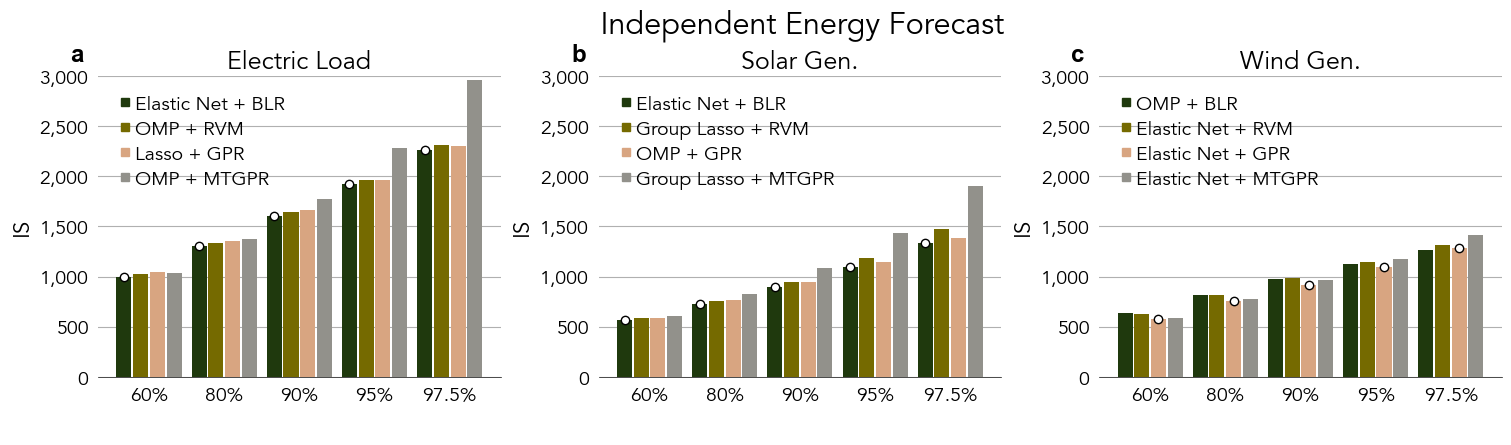

In [613]:
def _plot_interval_scores(ax, Scores_, zones_p_, colors_, resource, 
                          legend_labels_  = [], 
                          legend_title    = '' , 
                          score           = '', 
                          xlabel          = '',
                          ylabel          = '', 
                          title           = '', 
                          y_min           = 0,
                          y_max           = 3000,
                          legend          = False):
    

    interval_scores_ = ['IS60','IS80','IS90','IS95', 'IS975']
    dense_methods_   = Scores_['dense_method'].unique()

    x_ = np.linspace(0, .333*len(dense_methods_), len(dense_methods_))
    
    ax.set_title(title, size = 18)

    width  = 0.4
    offset = 2.

    ticks_  = []
    values_ = []
    j = 0
    legend_labels_ = []
    for interval_score in interval_scores_:
        i = 0
        for dense_method in dense_methods_:
     
            idx_1_ = (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            df_ = Scores_.loc[idx_1_ & (Scores_['IS'] == Scores_.loc[idx_1_, 'IS'].min())]

            if (j == 0):
                sparse_method = df_['sparse_method'].to_list()[0].replace('_', ' ').title()
                if sparse_method == 'Omp': sparse_method = 'OMP'
                legend_labels_.append(r'{} + {}'.format(sparse_method, dense_method))
                
            p = ax.bar(x_[i], df_[interval_score].min(), width, color  = colors_[i], 
                                                                zorder = 9, 
                                                                align  = 'center')
            
            if df_['IS'].min() == Scores_.loc[(Scores_['resource'] == resource) & (Scores_['score'] == score), 'IS'].min():
                ax.scatter(x_[i], df_[interval_score].min(), marker   = 'o', 
                                                             color     = 'w', 
                                                             edgecolor = 'k', 
                                                             lw        = 1., 
                                                             zorder    = 10)

            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    ax.set_xticks(ticks_[:len(interval_scores_)], ['60%', '80%', '90%', '95%', '97.5%'], fontsize = 10)
    
    ax.set_ylim(y_min, y_max)

    legend_ = []

    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0. ,
                   loc            = "upper left",
                   labelspacing   = .2,
                   #bbox_to_anchor = [1., .825],
                   frameon        = False)

    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c']], layout = 'constrained', figsize = (15, 4))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_interval_scores(_ax['a'], ts_scores_, zones_, colors_3_, resource = 'load', 
                                                               title    = 'Electric Load',
                                                               score    = 'IS',
                                                               ylabel   = 'IS',
                                                               xlabel   = ' ',
                                                               legend   = True, 
                                                               y_max    = 3000)

_plot_interval_scores(_ax['b'], ts_scores_, zones_, colors_3_, resource = 'solar', 
                                                               title    = 'Solar Gen.',
                                                               xlabel   = ' ',
                                                               score    = 'IS',
                                                               ylabel   = 'IS',
                                                               legend   = True, 
                                                               y_max    = 3000)

_plot_interval_scores(_ax['c'], ts_scores_, zones_, colors_3_, resource = 'wind', 
                                                               title    = 'Wind Gen.',
                                                               score    = 'IS',
                                                               ylabel   = 'IS',
                                                               xlabel   = ' ',
                                                               legend   = True, 
                                                               y_max    = 3000)


plt.suptitle('           Independent Energy Forecast', fontsize = 22, y = 1.075)

plt.savefig(path_to_images + f'ind_IS.pdf', bbox_inches = 'tight',
                                            dpi         = 300)

plt.show()


In [563]:
# def _load_computing_time(resources_, sl_models_, dl_models_, scores_, N_tr):

#     time_ = []
#     for resource in resources_:  
#         for score in scores_:
#             for sl_model in sl_models_:
#                 for dl_model in dl_models_:

#                     filename = '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, score)

#                     with open(path_to_mdls + filename, 'rb') as f:
#                         _model = pickle.load(f)   
                        
#                     tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
#                     ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_tr

#                     time_.append([resource, score, sl_model, dl_model, tr, ts])

#     return pd.DataFrame(np.stack(time_), columns = ['resource', 'score', 'sparse_method', 'dense_method', 'train', 'test'])


# time_ = _load_computing_time(resources_ = ['load', 'solar', 'wind'], 
#                              sl_models_ = ['OMP', 'lasso', 'elastic_net', 'group_lasso'], 
#                              dl_models_ = ['BLR', 'RVM', 'GPR', 'MTGPR'], 
#                              scores_    = ['ES', 'VS', 'LogS'], 
#                              N_tr       = 243)

In [564]:
# def _plot_results(ax, ts_scores_, sl_models_, dl_models_, resource, score, criteria, colors_, 
#                   units        = 1.,
#                   y_min        = 0., 
#                   y_max        = 0., 
#                   legend_labels_ = [],
#                   suptitle     = '', 
#                   title        = '', 
#                   legend_title = '', 
#                   letter       = '',
#                   legend       = False, 
#                   decimals     = False):

#     markers_       = ['o', 'p', '^', 'd']

#     width  = 0.15
#     offset = 1.

#     x_ = np.linspace(0, width*len(sl_models_), len(sl_models_))

#     # fig = plt.figure(figsize = (3.5, 3.))
#     # ax  = plt.subplot(111)

#     ticks_ = []
#     j = 0
#     for dl_model in dl_models_:

#         i = 0
#         y_ = []
#         for sl_model in sl_models_:

#             idx_1_ = (ts_scores_['resource'] == resource) & (ts_scores_['score'] == criteria)
#             idx_2_ = (ts_scores_['sparse_method'] == sl_model) & (ts_scores_['dense_method'] == dl_model)

#             y_.append(ts_scores_.loc[idx_1_ & idx_2_, score].min())
            
#             if ts_scores_.loc[idx_1_, score].min() == ts_scores_.loc[idx_1_ & idx_2_, score].min():
#                 if score == criteria:
#                     ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 200, edgecolor = 'k', lw = 1., color = colors_[i], zorder = 10)
#                 else:
#                     ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 200, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)
#             else:
#                 ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 150, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)

#             i +=1 
#         ax.plot(x_, y_, lw = 1., zorder = 9, marker = '.', color = 'k')
#         j += 1
#         ticks_.append(x_.mean())
#         x_ += offset

#     ax.xaxis.set_tick_params(labelsize = 18)
#     ax.yaxis.set_tick_params(labelsize = 14)
#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     if decimals: ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

#     ax.set_ylabel(score, fontsize = 18)
#     # plt.xlabel(xlabel, fontsize = 16)

#     ax.set_xticks(ticks_[:len(dl_models_)], dl_models_, fontsize = 18)

#     #ax.set_ylim(y_min, y_max)

#     legend_ = []
#     for i in range(len(legend_labels_)):
#         legend_.append(Line2D([0], [0], marker          = 's', 
#                                         markerfacecolor = colors_[i], 
#                                         markeredgecolor = colors_[i], 
#                                         markersize      = 6,
#                                         label           = legend_labels_[i],
#                                         color           = "None"))
#     if legend:
#         _leg_1 = plt.legend(handles        = legend_, 
#                             title          = legend_title, 
#                             prop           = {'size': 12}, 
#                             title_fontsize = 14,
#                             ncol           = 1, 
#                             columnspacing  = 0., 
#                             handletextpad  = 0.,  
#                             bbox_to_anchor = [.975, .8],
#                             frameon        = False)
#         ax.add_artist(_leg_1)


#     legend_ = []

#     legend_.append(Line2D([0], [0], marker          = 'o', 
#                                     markerfacecolor = None, 
#                                     markeredgecolor = 'k', 
#                                     markersize      = 4,
#                                     label           = 'median',
#                                     color           = "None"))

#     legend_.append(Line2D([0], [0], marker          = '_', 
#                                     markerfacecolor = "silver", 
#                                     markeredgecolor = "silver", 
#                                     markersize      = 6,
#                                     label           = 'mean',
#                                     color           = "None"))
#     if legend:
#         _leg_2 = plt.legend(handles        = legend_, 
#                             prop           = {'size': 14}, 
#                             title_fontsize = 14,
#                             ncol           = 1, 
#                             columnspacing  = 0., 
#                             handletextpad  = 0.,  
#                             bbox_to_anchor = [0.35, .65],
#                             #loc            = 'upper left',
#                             frameon        = False)

#         ax.add_artist(_leg_2)
        


    
#     ax.grid(axis      = 'y', 
#             alpha     = .5, 
#             linestyle = '-')
    
    


In [358]:
# criteria = 'ES'
# resource = 'wind'

# for criteria in ['ES', 'LogS', 'VS']:
#     for resource in ['load', 'solar', 'wind']:
#         print(criteria, resource)

#         fig, (_ax1, _ax2, _ax3) = plt.subplots(1, 3, figsize = (15, 5))

#         _plot_results(_ax1, ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
#                                                             criteria       = criteria,
#                                                             score          = 'ES', 
#                                                             y_min          = 30, 
#                                                             y_max          = 35, 
#                                                             legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
#                                                             colors_        = colors_1_,
#                                                             legend_title   = 'Sparse Learning', 
#                                                             legend         = False, 
#                                                             decimals       = False)

#         #_ax2.set_title('Independent Forecast', fontsize = 18, y = 1.05, x = 1.5)

#         _plot_results(_ax2, ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
#                                                             criteria       = criteria,
#                                                             score          = 'LogS', 
#                                                             y_min          = 6.5, 
#                                                             y_max          = 8., 
#                                                             legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
#                                                             colors_        = colors_1_,
#                                                             legend_title   = 'Sparse Learning', 
#                                                             legend         = False, 
#                                                             decimals       = True)

#         _plot_results(_ax3, ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
#                                                             criteria       = criteria,
#                                                             score          = 'VS', 
#                                                             y_min          = 2000, 
#                                                             y_max          = 3000, 
#                                                             legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
#                                                             colors_        = colors_1_,
#                                                             legend_title   = 'Sparse Learning', 
#                                                             legend         = False, 
#                                                             decimals       = False)

#         sns.despine(trim   = True, 
#                     offset = 0)

#         #plt.suptitle('     Wind Gen.', fontsize = 24, y = 1)

#         fig.tight_layout()

#         plt.savefig(path_to_images + f'boxplot_{resource}_{criteria}.pdf', bbox_inches = 'tight',
#                                                                            dpi         = 300)

#         plt.show()

In [605]:
def _plot_results(ax, ts_scores_, sl_models_, dl_models_, resource, score, criteria, colors_, 
                  units        = 1.,
                  y_min        = 0., 
                  y_max        = 0., 
                  legend_labels_ = [],
                  suptitle     = '', 
                  title        = '', 
                  legend_title = '', 
                  letter       = '',
                  legend       = False, 
                  decimals     = False):

    width    = 0.15
    offset   = 1.
    markers_ = ['o', 'p', '^', 'd']

    j      = 0
    ticks_ = []
    x_     = np.linspace(0, width*len(sl_models_), len(sl_models_))
    for dl_model in dl_models_:

        i  = 0
        y_ = []
        for sl_model in sl_models_:

            idx_1_ = (ts_scores_['resource'] == resource) & (ts_scores_['score'] == criteria)
            idx_2_ = (ts_scores_['sparse_method'] == sl_model) & (ts_scores_['dense_method'] == dl_model)

            y_.append(ts_scores_.loc[idx_1_ & idx_2_, score].min())
            
            if ts_scores_.loc[idx_1_, score].min() == ts_scores_.loc[idx_1_ & idx_2_, score].min():
                if score == criteria:
                    ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                    s         = 240, 
                                                    edgecolor = 'k', 
                                                    lw        = 1., 
                                                    color     = colors_[i], 
                                                    zorder    = 10)
                else:
                    ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                    s         = 240, 
                                                    edgecolor = 'w', 
                                                    lw        = .5, 
                                                    color     = colors_[i], 
                                                    zorder    = 10)
            else:
                ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                s         = 140, 
                                                edgecolor = 'w', 
                                                lw        = .5, 
                                                color     = colors_[i], 
                                                zorder    = 10)

            i +=1 
        ax.plot(x_, y_, lw     = 1., 
                        zorder = 9, 
                        marker = '.', 
                        color  = 'k')
        j += 1
        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if decimals: ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel(score, fontsize = 16)
    # plt.xlabel(xlabel, fontsize = 16)

    ax.set_xticks(ticks_[:len(dl_models_)], ['BLR', 'RVM', 'GPR', 'MNGPR'], fontsize = 18)

    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 14}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [0.35, .65],
                            #loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
    
    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')
    
def _plot_time(ax, time_, resource, score, colors_, 
               suptitle = '', 
               title    = '', 
               legend   = True, 
               y_min    = 1, 
               x_max    = 1):

    markers_       = ['o', 'p', '^', 'd']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = (time_['resource'] == resource) & (time_['score'] == score)

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)

    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for dl_method in time_['dense_method'].unique():

            idx_3_ = time_['dense_method'] == dl_method

            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            if j == 0:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 300., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.75,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)
            else:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 300., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.8,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    ax.set_ylabel('Training Time (s)', fontsize = 16)
    ax.set_xlabel('Testing Time (s)', fontsize = 16)

    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = 10,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .65],
                            frameon        = False)
        ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'BLR'))

    legend_.append(Line2D([0], [0], marker          = 'p', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 17,
                                    markeredgewidth = .5,
                                    label           = 'RVM'))

    legend_.append(Line2D([0], [0], marker          = '^', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'GPR'))

    legend_.append(Line2D([0], [0], marker          = 'd', 
                                    color           = "None",
                                    markerfacecolor = 'None', 
                                    markeredgecolor = "k", 
                                    markersize      = 13,
                                    markeredgewidth = .5,
                                    label           = 'MNGPR'))

    if legend:
        _leg_2 = ax.legend(handles         = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 4, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .125],
                            frameon        = False)
        
        ax.add_artist(_leg_2)

    ax.set_ylim(1, 10000)
    ax.set_xlim(0, x_max)
    
    
def _plot_fs(ax, Scores_, zones_, resource, colors_, 
             score          = 'RMSE',
             legend_labels_ = [], 
             legend_title   = '', 
             ndecimals      = 0,
             xlabel         = '',
             ylabel         = '', 
             legend         = False,
             y_min          = -5, 
             y_max          = 15):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()

    width  = 0.4
    offset = 2.
    x_      = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    j       = 0
    ticks_  = []
    values_ = []
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method)
            idx_2_ = (Scores_['resource'] == resource) & (Scores_['score'] == score)

            p = ax.bar(x_[i], Scores_.loc[idx_1_ & idx_2_, 'FS'].min(), width, color  = colors_[i], 
                                                                               zorder = 9, 
                                                                               align  = 'center')
                
            ax.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size     = 12, 
                                                                          rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
        
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles         = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_xticks(ticks_[:len(dense_methods_)], ['BLR', 'RVM', 'GPR', 'MNGPR'], fontsize = 14)

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

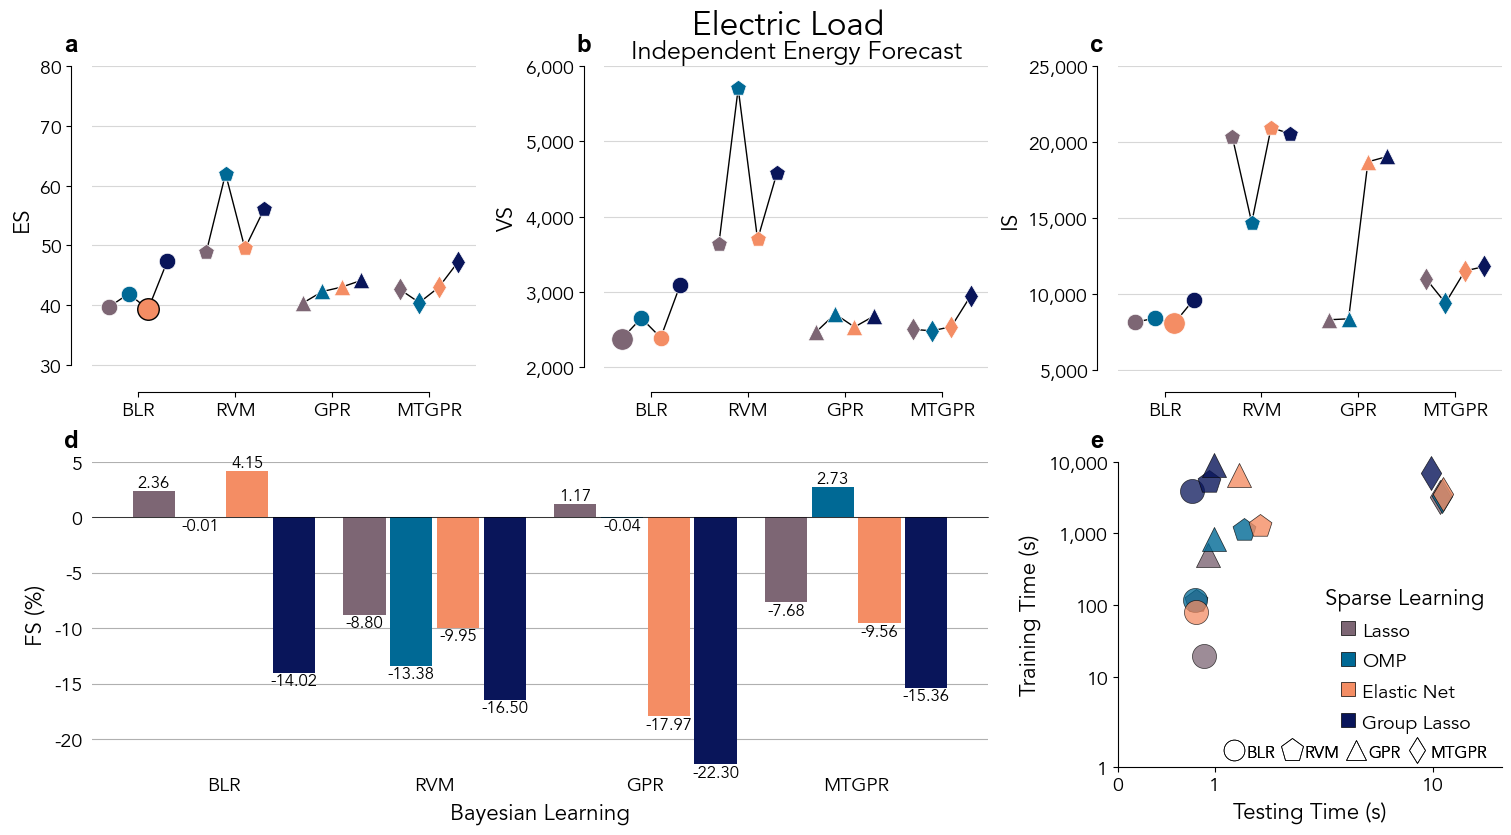

In [606]:
resource = 'load'
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 29, 
                                                              y_max          = 80, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Independent Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1950, 
                                                              y_max          = 6000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])


_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 4950, 
                                                              y_max          = 25000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)


sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('       Electric Load', fontsize = 24, y = 1.025)


_plot_fs(_ax['d'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       ndecimals      = 2, 
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = 'FS (%)',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -22.5, 
                                       y_max          = 5)

_plot_time(_ax['e'], time_, resource = resource, 
                            score    = criteria, 
                            colors_  = colors_1_, 
                            legend   = True, 
                            x_max    = 25)


plt.savefig(path_to_images + f'ind_model_selection_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                               dpi         = 300)

plt.show()

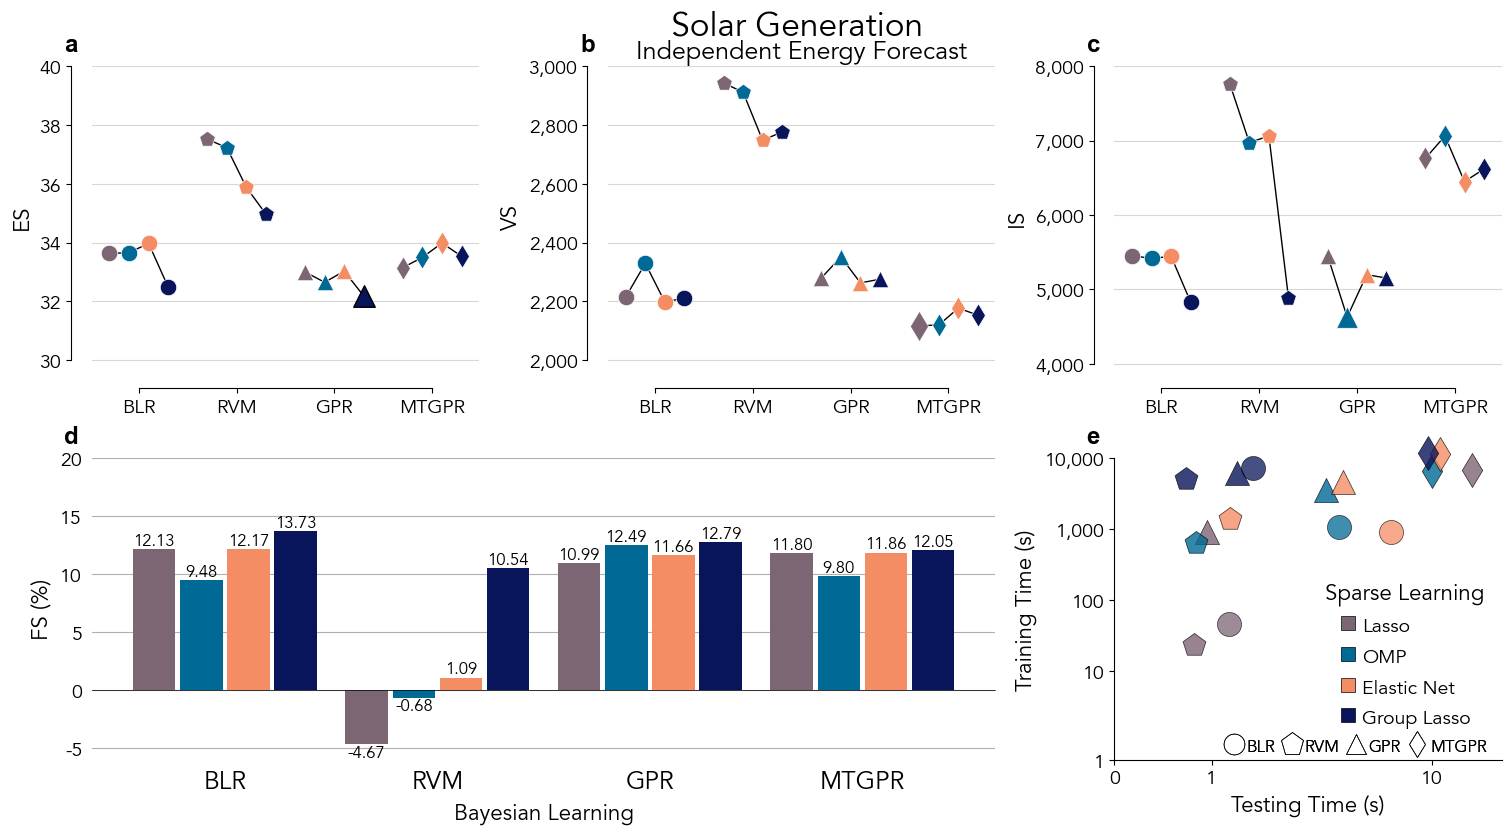

In [595]:
resource = 'solar'
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 29.75, 
                                                              y_max          = 40, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Independent Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1975, 
                                                              y_max          = 3000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 3950, 
                                                              y_max          = 8000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('         Solar Generation', fontsize = 24, y = 1.025)


_plot_fs(_ax['d'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       ndecimals      = 2, 
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = 'FS (%)',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -6, 
                                       y_max          = 20)

_plot_time(_ax['e'], time_, resource = resource, 
                            score    = criteria, 
                            colors_  = colors_1_, 
                            title    = criteria, 
                            legend   = True, 
                            x_max    = 25)


plt.savefig(path_to_images + f'ind_model_selection_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                               dpi         = 300)

plt.show()

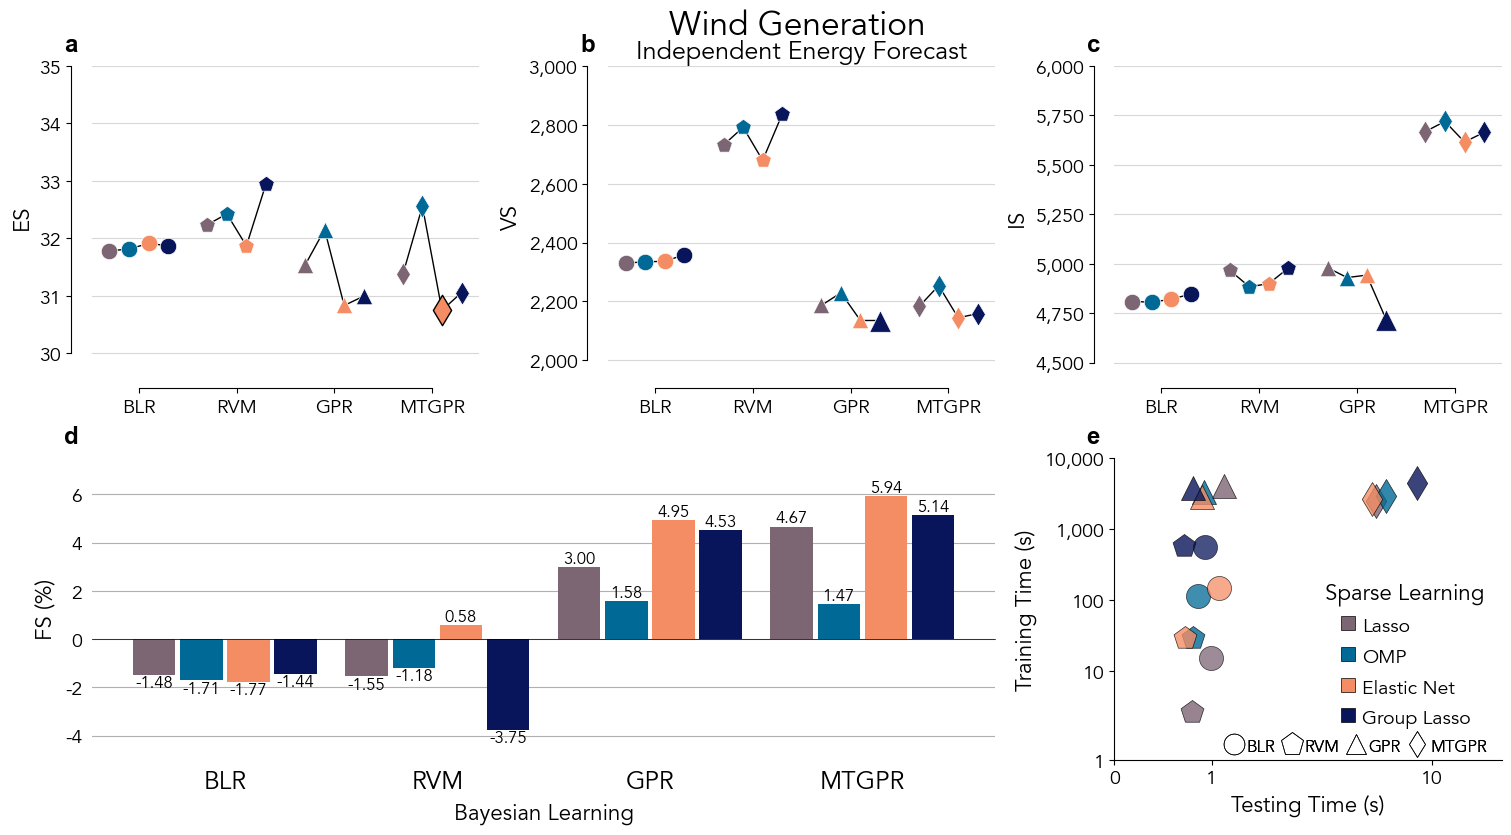

In [602]:
resource = 'wind'
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 29.75, 
                                                              y_max          = 35, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Independent Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1975, 
                                                              y_max          = 3000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 4475, 
                                                              y_max          = 6000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('         Wind Generation', fontsize = 24, y = 1.025)


_plot_fs(_ax['d'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       ndecimals      = 2, 
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = 'FS (%)',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -5, 
                                       y_max          = 7.5)

_plot_time(_ax['e'], time_, resource = resource, 
                            score    = criteria, 
                            colors_  = colors_1_, 
                            title    = criteria, 
                            legend   = True, 
                            x_max    = 25)


plt.savefig(path_to_images + f'ind_model_selection_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                               dpi         = 300)

plt.show()

## Solar Model Selection

In [209]:
resources_  = ['solar']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['RMSE', 'LogS', 'ES', 'VS', 'IS']
bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

val_scores_ = _load_val_scores(resources_, dl_methods_, sl_methods_, zones_, scores_)
#val_scores_.to_csv(path_to_mdls + 'prob_model_selection_{}.csv'.format(resources_[-1]), index = False)
#print(val_scores_)

In [210]:
ts_scores_s_ = _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, bay_scores_)
#print(ts_scores_)

### Solar Models Forecasting Skill

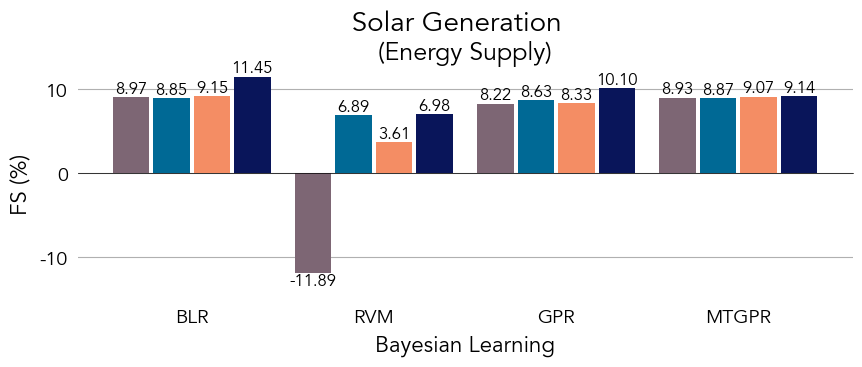

In [211]:
_make_fs_plot(ts_scores_s_, ref_, zones_, resource       = 'solar', 
                                          colors_        = colors_1_, 
                                          score          = 'RMSE',
                                          ndecimals      = 2, 
                                          legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                          xlabel         = 'Bayesian Learning',
                                          ylabel         = 'FS (%)',
                                          legend_title   = 'Sparse Learning',
                                          save           = True, 
                                          legend         = False, 
                                          suptitle       = r' Solar Generation', 
                                          title          = r'(Energy Supply)',
                                          filename       = 'fs_{}_{}.png')

### Solar Models Interval Scores

In [212]:
print(ts_scores_s_.loc[ts_scores_s_['IS'] == ts_scores_s_['IS'].min()])

   resource sparse_method dense_method score        RMSE                  IS  \
16    solar         lasso          BLR  LogS  331.728643  1026.1070375669399   

                  LogS                 ES                 VS        IS60  \
16  5.8475233623229785  32.11559017959966  2222.181250455734  659.333493   

                IS80                IS90                IS95  \
16  835.800458479817  1017.3629862594865  1206.0485391041182   

                 IS975  
16  1411.9897107624925  


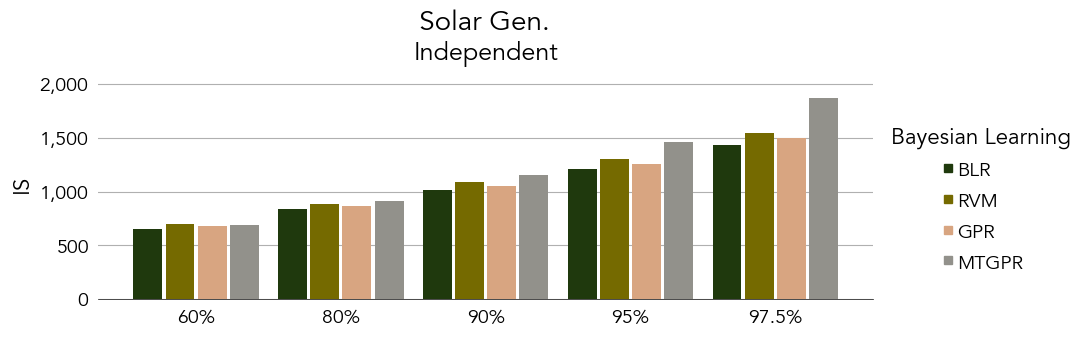

In [213]:
_make_inteval_scores_plot(ts_scores_s_, zones_, resource        = 'solar', 
                                                colors_         = colors_3_, 
                                                ndecimals       = 0, 
                                                legend_labels_  = ['BLR','RVM','GPR', 'MTGPR'], 
                                                score           = 'IS',
                                                ylabel          = 'IS',
                                                legend_title    = 'Bayesian Learning',
                                                labels          = False,
                                                save            = True, 
                                                legend          = True, 
                                                title           = 'Independent',
                                                suptitle        = '   Solar Gen.',
                                                filename        = 'is_is_solar.png',
                                                label_font_size = 9.)

### Solar Models Scoring Rules - Bar Plot

In [214]:
# _make_scores_plot(ts_scores_, zones_, resource       = 'solar', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 2, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'ES',
#                                       xlabel         = 'Bayesian Learning',
#                                       ylabel         = 'ES',
#                                       legend_title   = 'Sparse Learning',
#                                       save           = True, 
#                                       legend         = True, 
#                                       filename       = 'score_bar_{}_{}.png')

# _make_scores_plot(ts_scores_, zones_, resource       = 'solar', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 0, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'VS',
#                                       xlabel         = 'Bayesian Learning',
#                                       ylabel         = 'VS',
#                                       legend_title   = 'Sparse Learning',
#                                       save           = True, 
#                                       legend         = False, 
#                                       filename       = 'score_bar_{}_{}.png')

# _make_scores_plot(ts_scores_, zones_, resource       = 'solar', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 3, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'LogS',
#                                       xlabel         = r'Bayesian Learning',
#                                       ylabel         = 'LogS',
#                                       legend_title   = r'Sparse Learning',
#                                       save           = True, 
#                                       legend         = False, 
#                                       filename       = 'score_bar_{}_{}.png')

### Solar Models Scoring Rules - Box Plot

In [215]:
_results = _load_sample_scores(resources_ = resources_, 
                               sl_models_ = sl_methods_, 
                               dl_models_ = dl_methods_, 
                               scores_    = ['ES', 'LogS', 'VS'])

TypeError: _load_sample_scores() missing 1 required positional argument: 'criteria_'

In [216]:
_plot_box(_results, sl_methods_, dl_methods_, resource       = 'solar', 
                                              score          = 'LogS', 
                                              y_min          = 0, 
                                              y_max          = 200, 
                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                              colors_        = colors_1_,
                                              legend         = False, 
                                              legend_title   = 'Sparse Learning', 
                                              suptitle       = r' Solar Gen.', 
                                              title          = r'Independent',
                                              save           = True,
                                              path           = path_to_images, 
                                              filename       = 'ES_boxplot_solar_LogS.png')

_plot_box(_results, sl_methods_, dl_methods_, resource       = 'solar', 
                                              score          = 'LogS', 
                                              y_min          = 4, 
                                              y_max          = 14, 
                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                              colors_        = colors_1_,
                                              legend         = False, 
                                              legend_title   = 'Sparse Learning', 
                                              save           = True,
                                              path           = path_to_images, 
                                              filename       = 'LogS_boxplot_solar_LogS.png')

_plot_box(_results, sl_methods_, dl_methods_, resource       = 'solar', 
                                              score          = 'LogS', 
                                              y_min          = 0, 
                                              y_max          = 20000, 
                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                              colors_        = colors_1_,
                                              legend         = True, 
                                              legend_title   = 'Sparse Learning', 
                                              save           = True,
                                              path           = path_to_images, 
                                              filename       = 'VS_boxplot_solar_LogS.png')

TypeError: _plot_box() missing 1 required positional argument: 'criteria'

## Wind Model Selection

In [229]:
resources_  = ['wind']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
zones_      = ['NP15', 'SP15']
scores_     = ['RMSE', 'LogS', 'ES', 'VS', 'IS']
bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

val_scores_ = _load_val_scores(resources_, dl_methods_, sl_methods_, zones_, scores_)
#val_scores_.to_csv(path_to_mdls + 'prob_model_selection_{}.csv'.format(resources_[-1]), index = False)
#print(val_scores_)

In [230]:
ts_scores_w_ = _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, bay_scores_)
#print(ts_scores_)

### Wind Models Forecasting Skill

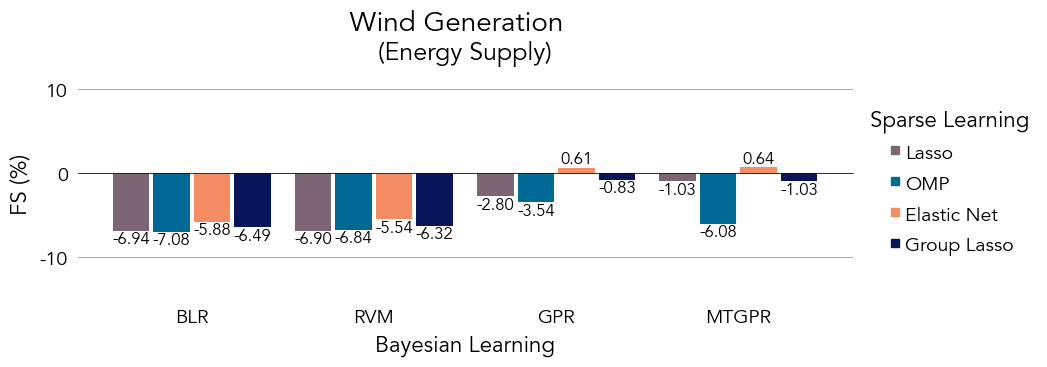

In [231]:
_make_fs_plot(ts_scores_w_, ref_, zones_, resource       = 'wind', 
                                          colors_        = colors_1_, 
                                          score          = 'RMSE',
                                          ndecimals      = 2, 
                                          legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                          xlabel         = 'Bayesian Learning',
                                          ylabel         = 'FS (%)',
                                          legend_title   = 'Sparse Learning',
                                          suptitle       = r' Wind Generation', 
                                          title          = r'(Energy Supply)',
                                          save           = True, 
                                          legend         = True, 
                                          filename       = 'fs_{}_{}.png')

### Wind Models Interval Scores

In [232]:
print(ts_scores_w_.loc[ts_scores_w_['IS'] == ts_scores_w_['IS'].min()])
print(ts_scores_w_)

   resource sparse_method dense_method score        RMSE                  IS  \
26     wind   elastic_net          GPR  LogS  275.546509  1256.0458468665768   

                 LogS                  ES                 VS        IS60  \
26  6.965906771301991  30.786585741177433  2110.730392350864  758.237141   

                 IS80                IS90                IS95  \
26  993.5143640063329  1231.9018620758713  1496.1040069081591   

                 IS975  
26  1800.4718599769442  
   resource sparse_method dense_method score        RMSE                  IS  \
0      wind         lasso          BLR  RMSE  296.603883  1286.2792891426625   
1      wind         lasso          RVM  RMSE  296.487349  1332.8802595679101   
2      wind         lasso          GPR  RMSE  285.103457  1320.2665765557963   
3      wind         lasso        MTGPR  RMSE  280.199282   1534.525404121639   
4      wind           OMP          BLR  RMSE  296.981157  1285.1387087770602   
..      ...           ...

In [434]:
_make_inteval_scores_plot(ts_scores_w_, zones_, resource        = 'wind', 
                                                colors_         = colors_3_, 
                                                ndecimals       = 0, 
                                                legend_labels_  = ['BLR','RVM','GPR', 'MTGPR'], 
                                                score           = 'IS',
                                                ylabel          = 'IS',
                                                legend_title    = 'Bayesian Learning',
                                                labels          = False,
                                                save            = True, 
                                                legend          = False, 
                                                filename        = 'is_is_wind.png',
                                                suptitle        = '   Wind Gen.',
                                                title           = 'Independent',
                                                label_font_size = 9.)

NameError: name 'ts_scores_w_' is not defined

### Wind Models Scoring Rules - Bar Plot

In [135]:
# _make_scores_plot(ts_scores_, zones_, resource       = 'wind', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 2, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'ES',
#                                       xlabel         = 'Bayesian Learning',
#                                       ylabel         = 'ES',
#                                       legend_title   = 'Sparse Learning',
#                                       save           = True, 
#                                       legend         = True, 
#                                       filename       = 'scores_bar_{}_{}.png')

# _make_scores_plot(ts_scores_, zones_, resource       = 'wind', 
#                                      colors_        = colors_1_, 
#                                      ndecimals      = 0, 
#                                      legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                      score          = 'VS',
#                                      xlabel         = 'Bayesian Learning',
#                                      ylabel         = 'VS',
#                                      legend_title   = 'Sparse Learning',
#                                      save           = True, 
#                                      legend         = False, 
#                                      filename       = 'scores_bar_{}_{}.png')

# _make_scores_plot(ts_scores_, zones_, resource       = 'wind', 
#                                       colors_        = colors_1_, 
#                                       ndecimals      = 3, 
#                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
#                                       score          = 'LogS',
#                                       xlabel         = 'Bayesian Learning',
#                                       ylabel         = 'LogS',
#                                       legend_title   = 'Sparse Learning',
#                                       save           = True, 
#                                       legend         = False, 
#                                       filename       = 'scores_bar_{}_{}.png')

### Wind Models Scoring Rules - Box Plot

In [185]:
_results = _load_sample_scores(resources_ = resources_, 
                               sl_models_ = sl_methods_, 
                               dl_models_ = dl_methods_, 
                               scores_    = ['ES', 'LogS', 'VS'])

NameError: name '_load_sample_scores' is not defined

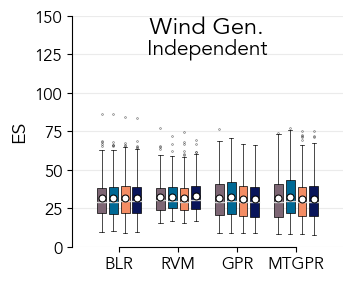

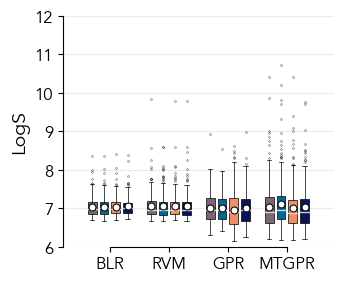

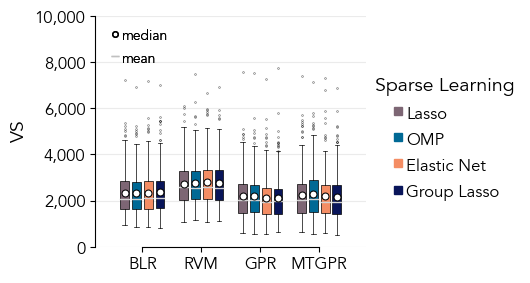

In [151]:
_plot_box(_results, sl_methods_, dl_methods_, resource       = 'wind', 
                                              score          = 'ES', 
                                              y_min          = 0, 
                                              y_max          = 150, 
                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                              colors_        = colors_1_,
                                              legend         = False, 
                                              legend_title   = 'Sparse Learning', 
                                              save           = True,
                                              suptitle       = r' Wind Gen.', 
                                              title          = r'Independent',
                                              path           = path_to_images, 
                                              filename       = 'scores_box_wind_ES.png')

_plot_box(_results, sl_methods_, dl_methods_, resource       = 'wind', 
                                              score          = 'LogS', 
                                              y_min          = 6, 
                                              y_max          = 12, 
                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                              colors_        = colors_1_,
                                              legend         = False, 
                                              legend_title   = 'Sparse Learning', 
                                              save           = True,
                                              path           = path_to_images, 
                                              filename       = 'scores_box_wind_LogS.png')

_plot_box(_results, sl_methods_, dl_methods_, resource       = 'wind', 
                                              score          = 'VS', 
                                              y_min          = 0, 
                                              y_max          = 10000, 
                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                              colors_        = colors_1_,
                                              legend         = True, 
                                              legend_title   = 'Sparse Learning', 
                                              save           = True,
                                              path           = path_to_images, 
                                              filename       = 'scores_box_wind_VS.png')

In [153]:
ts_scores_ = pd.concat([ts_scores_l_, ts_scores_s_, ts_scores_w_]).reset_index(drop = True)
#print(ts_scores_)

ts_scores_['IS60']  = ts_scores_['IS60'].astype(float)
ts_scores_['IS80']  = ts_scores_['IS80'].astype(float)
ts_scores_['IS90']  = ts_scores_['IS90'].astype(float)
ts_scores_['IS95']  = ts_scores_['IS95'].astype(float)
ts_scores_['IS975'] = ts_scores_['IS975'].astype(float)
ts_scores_['ES']    = ts_scores_['ES'].astype(float)
ts_scores_['VS']    = ts_scores_['VS'].astype(float)
ts_scores_['LogS']  = ts_scores_['LogS'].astype(float)

ts_scores_ = ts_scores_.groupby(['sparse_method', 'dense_method', 'score']).sum().reset_index()
ts_scores_['IS'] = ts_scores_['IS60'] + ts_scores_['IS80'] + ts_scores_['IS90'] + ts_scores_['IS95'] + ts_scores_['IS975']
ts_scores_ = ts_scores_.drop(columns = ['RMSE', 'LogS', 'ES', 'VS'])
ts_scores_.to_csv('independent_resources_IS.csv')
print(ts_scores_.loc[ts_scores_['IS'] == ts_scores_['IS'].min()])


   sparse_method dense_method score         IS60         IS80        IS90  \
62         lasso          BLR  LogS  2711.442711  3495.623756  4227.23954   

           IS95        IS975            IS  
62  4944.724714  5683.876573  21062.907294  


# Computing Time

In [205]:
def _load_computing_time(resources_, sl_models_, dl_models_, scores_, N_tr):

    time_ = []
    for resource in resources_:  
        for score in scores_:
            for sl_model in sl_models_:
                for dl_model in dl_models_:

                    filename = '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, score)

                    with open(path_to_mdls + filename, 'rb') as f:
                        _model = pickle.load(f)   
                        
                    tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_tr

                    time_.append([resource, score, sl_model, dl_model, tr, ts])

    return pd.DataFrame(np.stack(time_), columns = ['resource', 'score', 'sparse_method', 'dense_method', 'train', 'test'])

## Model Selection

In [206]:
time_ = _load_computing_time(resources_ = ['load', 'solar', 'wind'], 
                             sl_models_ = ['OMP', 'lasso', 'elastic_net', 'group_lasso'], 
                             dl_models_ = ['BLR', 'RVM', 'GPR', 'MTGPR'], 
                             scores_    = ['ES', 'VS', 'LogS'], 
                             N_tr       = 243)
    
#print(time_)

### Load Models Traning vs Testing Time

In [138]:
def _plot_computing_time(time_, resource, score, colors_, suptitle, title, save, legend, path, filename, y_min = 1, x_max = 1):

    markers_       = ['o', 'p', '^', 'd']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = (time_['resource'] == resource) & (time_['score'] == score)

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)


    fig = plt.figure(figsize = (5., 5.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 22, 
                           y        = 1.)
    plt.title(title, fontsize = 20, 
                     y        = .935)

    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for dl_method in time_['dense_method'].unique():

            idx_3_ = time_['dense_method'] == dl_method

            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            if j == 0:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 200., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.75,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)
            else:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 200., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.8,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    plt.xscale('symlog')
    plt.yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    plt.ylabel('Training Time (s)', fontsize = 16)
    plt.xlabel('Testing Time (s)', fontsize = 16)

    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = 10,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .65],
                            frameon        = False)
        ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'BLR'))

    legend_.append(Line2D([0], [0], marker          = 'p', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 17,
                                    markeredgewidth = .5,
                                    label           = 'RVM'))

    legend_.append(Line2D([0], [0], marker          = '^', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'GPR'))

    legend_.append(Line2D([0], [0], marker          = 'd', 
                                    color           = "None",
                                    markerfacecolor = 'None', 
                                    markeredgecolor = "k", 
                                    markersize      = 13,
                                    markeredgewidth = .5,
                                    label           = 'MTGPR'))

    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 4, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .125],
                            frameon        = False)
        ax.add_artist(_leg_2)

    plt.ylim(1, 10000)
    plt.xlim(0, x_max)

    if save:
        plt.savefig(path + filename, bbox_inches = 'tight',
                                     dpi         = 300)


    plt.show()
    


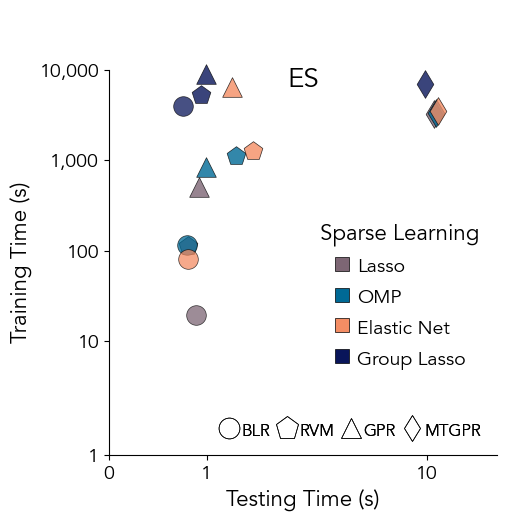

In [142]:
resource = 'load'
criteria = 'ES'

_plot_computing_time(time_, resource = resource, 
                            score    = criteria, 
                            colors_  = colors_1_, 
                            suptitle = ' ', 
                            title    = 'ES', 
                            save     = True, 
                            legend   = True, 
                            x_max    = 25,
                            path     = path_to_images, 
                            filename = f'is_computing_time_{resource}_{criteria}.pdf')

### Solar Models Traning vs Testing Time

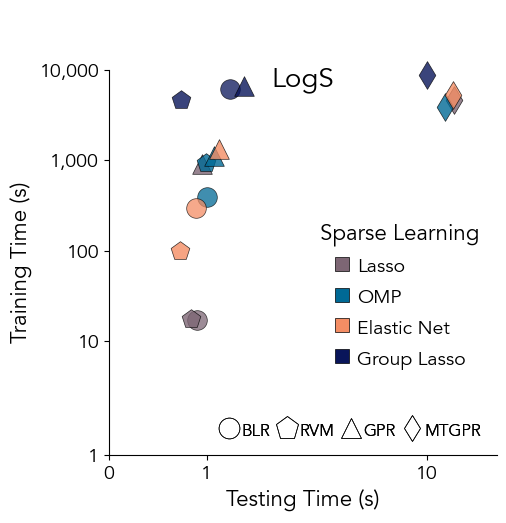

In [144]:
resource = 'solar'
criteria = 'LogS'

_plot_computing_time(time_, resource = resource, 
                            score    = criteria, 
                            colors_  = colors_1_, 
                            suptitle = ' ', 
                            title    = 'LogS', 
                            save     = True, 
                            legend   = True, 
                            x_max    = 25,
                            path     = path_to_images, 
                            filename = f'is_computing_time_{resource}_{criteria}.pdf')

### Wind Models Traning vs Testing Time

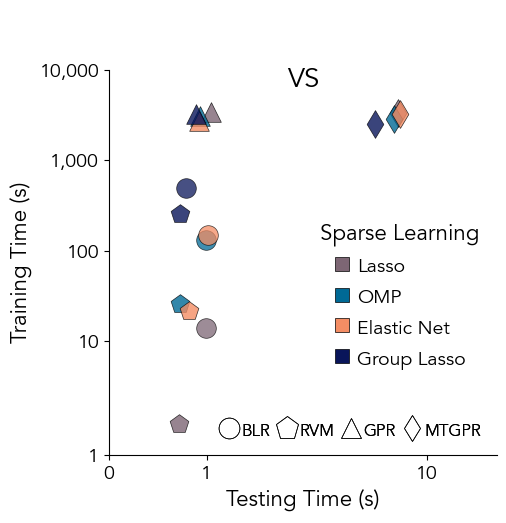

In [145]:
resource = 'wind'
criteria = 'VS'

_plot_computing_time(time_, resource = resource, 
                            score    = criteria, 
                            colors_  = colors_1_, 
                            suptitle = ' ', 
                            title    = 'VS', 
                            save     = True, 
                            legend   = True, 
                            x_max    = 25.,
                            path     = path_to_images, 
                            filename = f'is_computing_time_{resource}_{criteria}.pdf')

# Forecasting Example

In [433]:
# def _force_zero(x_):
#     x_[x_ < 0.] = 0.
#     return x_

# def _plot_confidence_intervals(_model, _baselines, meta_, zones_, i_sel_sample, i_zone, y_min     = 0.,
#                                                                                         y_max     = 0., 
#                                                                                         x_mark    = -1.,
#                                                                                         legend    = True, 
#                                                                                         path      = '',
#                                                                                         linestyle = '-',
#                                                                                         title     = '',
#                                                                                         save      = True, 
#                                                                                         file_name = 'noname.pdf', 
#                                                                                         letter    = '',
#                                                                                         colors_2_ = colors_2_):
    
#     zone      = zones_[i_zone]
#     z_scores_ = [0.84, 1.28, 1.64, 1.96, 2.24]
#     ci_       = [60, 80, 90, 95, 97.5]
#     colors_   = ['#99A3A4', '#B2BABB', '#CCD1D1', '#E0E0E0', '#E5E8E8']

#     y_       = _model['targets'][i_sel_sample, i_zone, :]
#     mu_      = _model['mean'][i_sel_sample, i_zone, :]
#     s2_      = np.sqrt(_model['variance'][i_sel_sample, i_zone, :])
#     Y_scens_ = _force_zero(_model['samples'][i_sel_sample, i_zone, :, :])

#     y_prs_ = _baselines['persitence'][i_sel_sample, i_zone, :]
#     y_clm_ = _baselines['climatology'][i_sel_sample, i_zone, :]
#     y_iso_ = _baselines['caiso'][i_sel_sample, i_zone, :]

#     if y_min == 0.:
#         y_min = _model['samples'][:, i_zone, :, :].min()
#     if y_max == 0.:
#         y_max = _model['samples'][:, i_zone, :, :].max()

#     x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

#     fig = plt.figure(figsize = (7.5, 3.))
#     ax  = plt.subplot(111)

#     plt.title(f'{zone}', fontsize = 14)

#     plt.suptitle(title, y = 1.05, x = 0.1, fontsize = 18, weight = "bold")
    
#     ax.plot(x_, _force_zero(y_), color     = 'r', 
#                                  linestyle = linestyle, 
#                                  label     = r'$y$ (ac)',
#                                  lw        = 1.5, 
#                                  alpha     = .75, 
#                                  zorder    = 12)


#     ax.plot(x_, _force_zero(mu_), color     = 'k', 
#                                   linestyle = '-', 
#                                   label     = r'$\mu$ (fc)',
#                                   lw        = .5, 
#                                   alpha     = 1., 
#                                   zorder    = 10)
    
#     ax.plot(x_, y_prs_, color     = colors_2_[0], 
#                         linestyle = '-', 
#                         label     = r'Per. (fc)',
#                         lw        = 1., 
#                         alpha     = 1., 
#                         zorder    = 11)

#     ax.plot(x_, y_clm_, color     = colors_2_[1], 
#                         linestyle = '-', 
#                         label     = r'Cli. (fc)',
#                         lw        = 1., 
#                         alpha     = 1., 
#                         zorder    = 11)

    
#     ax.plot(x_, y_iso_, color     = colors_2_[2], 
#                         linestyle = '-', 
#                         label     = r'CAISO (fc)',
#                         lw        = 1., 
#                         alpha     = 1., 
#                         zorder    = 11)

#     i = 0
#     for z, ci, color in zip(z_scores_, ci_, colors_):
#         ax.fill_between(x_, _force_zero(mu_ + z*s2_), _force_zero(mu_ - z*s2_), color  = color, 
#                                                                                 label  = f'{ci:02}%', 
#                                                                                 alpha  = .75, 
#                                                                                 zorder = 7 - i)
#         i += 1

#     if legend:
#         ax.legend(loc            = 'center', 
#                   bbox_to_anchor = (.5, 0.9),
#                   frameon        = False, 
#                   columnspacing = 0.4, 
#                   handletextpad = .2,
#                   ncol           = 11,
#                   prop           = {'size': 8.5})

#     ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

#     plt.xlim(0, 23)

#     ax.grid(axis = 'y')
#     ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

#     ax.yaxis.set_tick_params(labelsize = 10, 
#                              left      = False)

#     plt.ylim(y_min, y_max)

#     ax.text(-2.5, y_max*1.125, letter, fontsize = 20, 
#                                        weight   = "bold")

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)
        
#     ax.axvline(x_mark, linewidth = .5, 
#                        linestyle = ':', 
#                        color     = 'k', 
#                        clip_on   = False, 
#                        zorder    = 10)

#     if save: plt.savefig(path + file_name.format(zones_[i_zone], i_sel_sample), bbox_inches = 'tight', 
#                                                                                 dpi         = 250)

#     plt.show()
    
# def _plot_scenarios(_model, meta_, zones_, i_sel_sample, i_zone, y_min     = 0.,
#                                                                  y_max     = 0.,
#                                                                  legend    = True, 
#                                                                  path      = '',
#                                                                  x_mark    = -1.,
#                                                                  linestyle = '--',
#                                                                  save      = True, 
#                                                                  file_name = 'noname.pdf', 
#                                                                  letter    = ''):
    
#     y_       = _model['targets'][i_sel_sample, i_zone, :]
#     mu_      = _model['mean'][i_sel_sample, i_zone, :]
#     Y_scens_ = _model['samples'][i_sel_sample, ...]
#     #Y_scens_ = _smooth_gaussian(Y_scens_, sigma = _model['sigma'])
#     z_       = _eval_proba(_model, Y_scens_, i_sel_sample)
#     Y_scens_ = Y_scens_[i_zone, ...]

#     if y_min == 0.:
#         y_min = _model['samples'][:, i_zone, :, :].min()
#     if y_max == 0.:
#         y_max = _model['samples'][:, i_zone, :, :].max()

#     x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

#     fig = plt.figure(figsize = (7.5, 3.))
#     ax  = plt.subplot(111)

#     ax.plot(x_, _force_zero(y_), color     = 'r', 
#                                  linestyle = linestyle, 
#                                  label     = '$y$ (ac)',
#                                  lw        = 1.5, 
#                                  alpha     = .75, 
#                                  zorder    = 11)

#     z_p_ = np.cbrt(np.cbrt(np.cbrt(z_)))
        
#     _cmap = colors.LinearSegmentedColormap.from_list("my_colormap", ["lightgray", "silver", "gray", 'k'])
#     #_cmap = plt.get_cmap('inferno') 

#     _colormap = cm.ScalarMappable(norm = colors.Normalize(vmin = z_p_.min(), 
#                                                           vmax = z_p_.max()), cmap = _cmap)
#     _colormap.get_clim()

#     for i in np.argsort(z_p_):
        
#         if i == 0:
#             ax.plot(x_, Y_scens_[:, i], color     = 'gray', 
#                                         linestyle = '-', 
#                                         label     = '$y^\star_k$ (sc)',
#                                         lw        = 1., 
#                                         alpha     = 1., 
#                                         zorder    = 10)
            
#         ax.plot(x_, Y_scens_[:, i], color     = _colormap.to_rgba(z_p_[i]), 
#                                     linestyle = '-', 
#                                     lw        = 1., 
#                                     alpha     = .5, 
#                                     zorder    = 10)

#     if legend:
#         ax.legend(loc            = 'center', 
#                   bbox_to_anchor = (.85, 0.82),
#                   frameon        = False, 
#                   columnspacing = 0.5, 
#                   handletextpad = .25,
#                   ncol           = 2,
#                   prop           = {'size': 10})
        
#     ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

#     plt.xlim(0, 23)

#     ax.grid(axis = 'y')
#     ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

#     #ax.xaxis.set_tick_params(labelsize = 10, left = False)
#     ax.yaxis.set_tick_params(labelsize = 10, left = False)
    
#     plt.ylim(y_min, y_max)

#     ax.text(-2.5, y_max*1.25, letter, fontsize = 20, 
#                                       weight   = "bold")

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)
    
#     ax.axvline(x_mark, linewidth = .5, 
#                        linestyle = ':', 
#                        color     = 'k', 
#                        clip_on   = False, 
#                        zorder    = 10)
#     if legend:
#         fig.colorbar(_colormap, orientation = "horizontal", 
#                                 cax         = fig.add_axes([0.165, 0.72, 0.15, 0.05])  ,
#                                 ticks       = [],
#                                 extend      = 'max').set_label(r'$Pr(y^\star_k | \hat{\theta}, X^\star)$', 
#                                                                rotation = 0, 
#                                                                size     = 10)

#     if save: plt.savefig(path + file_name.format(zones_[i_zone], i_sel_sample), bbox_inches = 'tight', 
#                                                                                 dpi         = 250)


#     plt.show()
    
# def _plot_density_detail(_model, meta_, i_sel_sample_1, i_sel_sample_2, i_zone, x_mark    = 0,
#                                                                                 legend    = True, 
#                                                                                 y_min     = 0,
#                                                                                 y_max     = 25000.,
#                                                                                 path      = '',
#                                                                                 save      = True, 
#                                                                                 file_name = 'noname.pdf', 
#                                                                                 letter    = ''):
    
#     i_hour = x_mark
    
#     y_1        = _model['targets'][i_sel_sample_1, i_zone, i_hour]
#     mu_1       = _model['mean'][i_sel_sample_1, i_zone, i_hour]
#     s2_1       = np.sqrt(_model['variance'][i_sel_sample_1, i_zone, i_hour])
#     Y_scens_1_ = _model['samples'][i_sel_sample_1, ...]
    
#     y_2        = _model['targets'][i_sel_sample_2, i_zone, i_hour]
#     mu_2       = _model['mean'][i_sel_sample_2, i_zone, i_hour]
#     s2_2       = np.sqrt(_model['variance'][i_sel_sample_2, i_zone, i_hour])
#     Y_scens_2_ = _model['samples'][i_sel_sample_2, ...]
    
#     _N_1 = stats.norm(mu_1, s2_1)
#     _N_2 = stats.norm(mu_2, s2_2)
    
#     y_ = np.linspace(0., y_max, 1000)

#     fig = plt.figure(figsize = (3., 3.))
#     ax  = plt.subplot(111)

#     plt.title(r'{}:00'.format(i_hour), fontsize = 14)

# #     plt.title(f'{zone}', fontsize = 14)

#     ax.axhline(y_1, linewidth = 1., label = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_1, 'date']), 
#                     linestyle = '-', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)
    
#     ax.plot(_N_1.pdf(y_), y_, color     = 'k', 
#                               linestyle = '-', 
#                               lw        = .25, 
#                               alpha     = .5, 
#                               zorder    = 13)
    
#     ax.axhline(y_2, linewidth = 1., label = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_2, 'date']),
#                     linestyle = '--', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)

#     ax.plot(_N_2.pdf(y_), y_, color     = 'k', 
#                               linestyle = '-', 
#                               lw        = .25, 
#                               alpha     = .5, 
#                               zorder    = 7)
    
#     z_scores_ = [0.67, 1.15, 1.64, 1.96, 2.17, 2.32, np.inf]
#     ci_       = [50, 75, 90, 95, 97, 98, 100]
#     colors_   = ['#707B7C', '#99A3A4', '#B2BABB', '#CCD1D1', '#E5E8E8', '#F2F4F4', 'w']
    
#     i = 0
#     for z, ci, color in zip(z_scores_, ci_, colors_):
    
#         ax.fill_betweenx(y_, _N_1.pdf(y_), where       = (y_ < mu_1 + z*s2_1) & (y_ > mu_1 - z*s2_1), 
#                                            color       = color, 
#                                            alpha       = .75, 
#                                            zorder      = 12 - i,
#                                            interpolate = True)
        
#         ax.fill_betweenx(y_, _N_2.pdf(y_), where       = (y_ < mu_2 + z*s2_2) & (y_ > mu_2 - z*s2_2), 
#                                            color       = color, 
#                                            alpha       = .75, 
#                                            zorder      = 6 - i,
#                                            interpolate = True)
        
#         i += 1

#     if legend:
#         # ax.legend(loc            = 'upper center', 
#         #           bbox_to_anchor = (.65, 0.95),
#         #           frameon        = False,
#         #           prop           = {'size': 10})
#         ax.legend(frameon        = False,
#                   prop           = {'size': 10})
        
#     ax.set_xlabel(r'$p\left(y^\star_t\right)$', fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


#     ax.grid(axis = 'y')

#     #ax.xaxis.set_tick_params(labelsize = 10, left = False)
#     ax.yaxis.set_tick_params(labelsize = 10, left = False)

#     # if y_min < 0.:
#     #     y_min = -5
#     plt.ylim(-15., y_max)
#     plt.xlim(0., )

#     ax.text(-0.0002, y_max*1.05, letter, fontsize = 20, 
#                                       weight   = "bold")

#     # ax.text(0., y_max*1.25, scen_lable, fontsize = 16)

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)

#     ax.axvline(0, linewidth = .5, 
#                   linestyle = '-', 
#                   color     = 'k', 
#                   clip_on   = False, 
#                   zorder    = 10)


#     if save: plt.savefig(path + file_name.format(zones_[i_zone], i_sel_sample_1, i_sel_sample_2), bbox_inches = 'tight', 
#                                                                                                   dpi         = 300)


#     plt.show()
    
# def _plot_hist_detail(_model, meta_, i_sel_sample_1, i_sel_sample_2, i_zone, x_mark    = 0,nbins = 100,
#                                                                              legend    = True, 
#                                                                              y_min     = 0,
#                                                                              y_max     = 25000.,
#                                                                              path      = '',
#                                                                              save      = True, 
#                                                                              file_name = 'noname.pdf', 
#                                                                              letter    = ''):
    
#     i_hour = x_mark
    
#     y_1        = _model['targets'][i_sel_sample_1, i_zone, i_hour]
#     mu_1       = _model['mean'][i_sel_sample_1, i_zone, i_hour]
#     s2_1       = np.sqrt(_model['variance'][i_sel_sample_1, i_zone, i_hour])
#     Y_scens_1_ = _model['samples'][i_sel_sample_1, i_zone, i_hour, :]
    
#     y_2        = _model['targets'][i_sel_sample_2, i_zone, i_hour]
#     mu_2       = _model['mean'][i_sel_sample_2, i_zone, i_hour]
#     s2_2       = np.sqrt(_model['variance'][i_sel_sample_2, i_zone, i_hour])
#     Y_scens_2_ = _model['samples'][i_sel_sample_2, i_zone, i_hour, :]

#     _N_1 = stats.norm(mu_1, s2_1)
#     _N_2 = stats.norm(mu_2, s2_2)
    
#     y_ = np.linspace(0., y_max, 1000)

#     fig = plt.figure(figsize = (3., 3.))
#     ax  = plt.subplot(111)

#     plt.title(r'{}:00'.format(i_hour), fontsize = 14)

# #     plt.title(f'{zone}', fontsize = 14)

#     ax.axhline(y_1, linewidth = 1., label = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_1, 'date']), 
#                     linestyle = '-', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)
    
#     ax.plot(_N_1.pdf(y_), y_, color     = 'k', 
#                               linestyle = '-', 
#                               lw        = .25, 
#                               alpha     = .75, 
#                               zorder    = 13)
    
#     ax.hist(Y_scens_1_, bins        = nbins, 
#                         range       = (-15., y_max),
#                         color       = '#707B7C', 
#                         orientation = "horizontal", 
#                         zorder      = 1, 
#                         alpha       = 0.75, 
#                         density     = True, 
#                         edgecolor   ='k', 
#                         linewidth   = .25)
    
#     ax.axhline(y_2, linewidth = 1., label = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_2, 'date']),
#                     linestyle = '--', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)

#     ax.plot(_N_2.pdf(y_), y_, color     = 'k', 
#                               linestyle = '-', 
#                               lw        = .25, 
#                               alpha     = .75, 
#                               zorder    = 7)
    
#     ax.hist(Y_scens_2_, bins        = nbins, 
#                         range       = (-15., y_max), 
#                         color       = '#707B7C', 
#                         orientation = "horizontal", 
#                         zorder      = 1, 
#                         alpha       = 0.75, 
#                         density     = True, 
#                         edgecolor   ='k', 
#                         linewidth   = .25)

#     z_scores_ = [0.67, 1.15, 1.64, 1.96, 2.17, 2.32, np.inf]
#     ci_       = [50, 75, 90, 95, 97, 98, 100]
#     colors_   = ['#707B7C', '#99A3A4', '#B2BABB', '#CCD1D1', '#E5E8E8', '#F2F4F4', 'w']

#     if legend:
#         ax.legend(frameon = False,
#                   prop    = {'size': 10})
        
#     ax.set_xlabel(r'$p\left(y^\star_t\right)$', fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


#     ax.grid(axis = 'y')

#     #ax.xaxis.set_tick_params(labelsize = 10, left = False)
#     ax.yaxis.set_tick_params(labelsize = 10, left = False)

#     # if y_min < 0.:
#     #     y_min = -5
#     plt.ylim(-15., y_max)
#     plt.xlim(0., )

#     ax.text(-0.0002, y_max*1.05, letter, fontsize = 20, 
#                                       weight   = "bold")

#     # ax.text(0., y_max*1.25, scen_lable, fontsize = 16)

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)

#     ax.axvline(0, linewidth = .5, 
#                   linestyle = '-', 
#                   color     = 'k', 
#                   clip_on   = False, 
#                   zorder    = 10)


#     if save: plt.savefig(path + file_name.format(zones_[i_zone], i_sel_sample_1, i_sel_sample_2), bbox_inches = 'tight', 
#                                                                                                   dpi         = 300)


#     plt.show()
    
# def _load_model_data(zones_, model_name, baseline, i_zone):
    
#     _model = pd.read_pickle(path_to_mdls + model_name)

#     Y_ = _model['deterministic_scoring_all']
#     X_ = _model['baseline_scoring_all']

#     Y_ = Y_.loc[Y_['zone'] == zones_[i_zone]].reset_index(drop = True)
#     X_ = X_.loc[(X_['model'] == baseline) & (X_['zone'] == zones_[i_zone])].reset_index(drop = True)

#     Y_ = Y_.drop(columns = ['MBE', 'MAE', 'model', 'zone', 'sample']).rename(columns = {'RMSE': 'ml'})
#     X_ = X_.drop(columns = ['MBE', 'MAE', 'model', 'zone']).rename(columns = {'RMSE': 'caiso'})
#     X_ = pd.concat([X_, Y_], axis = 1)

#     X_['diff'] = X_['ml'] - X_['caiso']
#     X_['mean'] = np.mean(np.sqrt(_model['variance'])[:, i_zone, :], axis = 1)
#     X_['max']  = np.max(np.sqrt(_model['variance'])[:, i_zone, :], axis = 1)

#     meta_         = _model['targets_meta']
#     meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
#     meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')
    
#     return _model, X_, meta_

# # Rolling average window filter
# def _smooth_average(X_, span): 
#     N_dim, N_tasks, N_samples = X_.shape
#     Y_                        = np.zeros(X_.shape)
#     for i in range(N_dim):
#         for j in range(N_samples):
#             y_ = []
#             for t in range(N_tasks):
#                 if t - span < 0: x = 0
#                 else:            x = t - span
#                 if t + span + 1 > N_tasks: y = N_tasks
#                 else:                      y = t + span + 1
#                 y_.append(np.average(X_[i, x:y, j]))
#             Y_[i, :, j] = np.array(y_)
#     return Y_

# # Savitzky–Golay filter
# def _smooth_savgol(X_, span, degree):  
#     N_dim, N_tasks, N_samples = X_.shape
#     Y_                        = np.zeros(X_.shape)
#     for i in range(N_dim):
#         for j in range(N_samples):
#             Y_[i, :, j] = savgol_filter(X_[i, :, j], span * 2 + 1, degree)
#     return Y_

# # A LOWESS (Locally Weighted Scatterplot Smoothing) function that outs smoothed estimates 
# def _smooth_lowess(X_, span):
#     N_dim, N_tasks, N_samples = X_.shape
#     Y_                        = np.zeros(X_.shape)
#     x_                        = np.linspace(0, 1, N_tasks)
#     for i in range(N_dim):
#         for j in range(N_samples):
#             Y_[i, :, j] = sm.nonparametric.lowess(X_[i, :, j], x_, frac          = 1/span, 
#                                                                    return_sorted = False)
#     return Y_

# # Gaussian kernel filtering
# def _smooth_gaussian(X_, sigma):
#     N_tasks, N_dim, N_scen = X_.shape
#     Y_                        = np.zeros(X_.shape)
#     for i in range(N_tasks):
#         for j in range(N_scen):
#             Y_[i, :, j] = gaussian_filter1d(X_[i, :, j], sigma)
#     return Y_

# # Evaluate a scenario's predictive probability
# def _eval_proba(_model, Y_scens_, i_sel_sample):
#     mu_      = _model['mean'][i_sel_sample, ...]
#     Sigma_   = _model['covariance'][i_sel_sample, ...]

#     Z_ = np.zeros((Y_scens_.shape[1], Y_scens_.shape[2]))
#     for t in range(mu_.shape[1]):    
#         Z_[t, :] = multivariate_normal(mu_[:, t], Sigma_[..., t]).pdf(Y_scens_[:, t, :].T)
#     z_  = np.prod(Z_, axis = 0)
#     z_ /= z_.sum()
#     return z_

# # Variogram Score computed across temporal dimensions
# def _VS_temporal(Y_, Y_hat_, p = .5):
#     N_observation, N_tasks, N_horizons, N_samples = Y_hat_.shape
#     score_ = np.zeros((N_tasks, N_observation))
#     for t in range(N_tasks):
#         for n in range(N_observation):
#             frac1_ = np.absolute(np.subtract.outer(Y_[n, t, :], Y_[n, t, :]))**p
#             frac2_ = np.zeros((N_horizons, N_horizons))
#             for m in range(N_samples):
#                 frac2_ += np.absolute(np.subtract.outer(Y_hat_[n, t, :, m], Y_hat_[n, t, :, m]))**p
#             score_[t, n] = np.sum((frac1_ - (frac2_/N_samples))**2)
#     return score_

# # Average variograme score
# def _VS(Y_, Y_hat_):
#     VS_ = _VS_temporal(Y_, Y_hat_, p = .5)
#     VS_ = np.mean(VS_, axis = 1)
#     VS_ = np.mean(VS_, axis = 0)
#     return VS_

# # Energy Score across time
# def _ES_temporal(Y_, Y_hat_):
#     N_observation, N_tasks, N_horizons, N_samples = Y_hat_.shape
#     score_ = np.zeros((N_tasks, N_observation))

#     for t in range(N_tasks):
#         for n in range(N_observation):
#             Y_p_   = np.tile(Y_[n, t, :], (N_samples, 1)).T
#             frac1_ = np.sqrt(np.diag((Y_hat_[n, t, :, :] - Y_p_).T @ (Y_hat_[n, t, :, :] - Y_p_)))
#             frac2_ = 0
#             for m in range(N_samples):
#                 frac2_ += np.sqrt(np.sum((Y_hat_[n, t, :, :].T - Y_hat_[n, t, :, m])**2, axis = 1))
#             score_[t, n] = np.sum(frac1_)/N_samples - np.sum(frac2_)/(2*(N_samples**2))
#     return score_

# # Average energy score
# def _ES(Y_, Y_hat_):
#     ES_ = _ES_temporal(Y_, Y_hat_)
#     ES_ = np.mean(ES_, axis = 1)
#     ES_ = np.mean(ES_, axis = 0)
#     return ES_

# # Compute number of samples within the interval
# def _verify_predictive_intervals(Y_scens_, M_, S2_, z):
    
#     N_in = 0.
#     N_hours = 8
#     for i_sample in range(M_.shape[0]):
#         for i_zone in range(M_.shape[1]):
#             for i_hour in [8, 9, 10, 11, 12, 13, 14, 15]:
#                 y_    = Y_scens_[i_sample, i_zone, i_hour, :]
#                 mu    = M_[i_sample, i_zone, i_hour]
#                 std   = np.sqrt(S2_[i_sample, i_zone, i_hour])
#                 idx_  = (y_ > (mu - z*std)) & (y_ < (mu + z*std))
#                 N_in += idx_.sum()
            
#     return N_in/(Y_scens_.shape[0]*Y_scens_.shape[1]*N_hours*Y_scens_.shape[3])

# # Log-Score
# def _LogS(Y_, M_hat_, Cov_hat_):
#     # Multivaritate Normal Log Predictive Probability
#     def _mvNLPP(Y_, M_hat_, Cov_hat_):
#         z_ = np.zeros((Y_.shape[0], ))
#         for obv in range(M_hat_.shape[0]):
#             z_[obv] = multivariate_normal(M_hat_[obv, ...], Cov_hat_[obv, ...], 
#                                           allow_singular = True).logpdf(Y_[obv, ...])
#         return - z_    
#     # Samples / Tasks / Forecasting horizons
#     z_ = []
#     for i_scen in range(Y_.shape[-1]):
#         z_.append(np.sum(np.array([_mvNLPP(Y_[..., hrzn, i_scen], M_hat_[..., hrzn], Cov_hat_[..., hrzn]) 
#                                    for hrzn in [8, 9, 10, 11, 12, 13, 14, 15]]), axis = 1).mean())
#     return np.array(z_).mean()

# # Interval Score
# def _IS(y_, alpha, lower_, upper_):
#     score_  = (upper_ - lower_)
#     score_ += (2./alpha)*(lower_ - y_) * (1*(y_ < lower_))
#     score_ += (2./alpha)*(y_ - upper_) * (1*(y_ > upper_))
#     return score_

# def _interval_score(Y_, M_, S2_, z, alpha):
#     # 95% CI: z = 1.96; alpha = 0.05
#     # 90% CI: z = 1.645; alpha = 0.1
    
#     N_observation, N_tasks, N_horizons, N_scen = Y_.shape

#     score_ = np.zeros((N_observation, N_scen))
#     for s in range(N_scen):
#         Y_p_     = np.concatenate([Y_[:, tsk, :, s] for tsk in range(N_tasks)], axis = 1)
#         M_p_     = np.concatenate([M_[:, tsk, :] for tsk in range(N_tasks)], axis = 1)
#         S2_p_    = np.concatenate([S2_[:, tsk, :] for tsk in range(N_tasks)], axis = 1)
#         for n in range(N_observation):
#             score_[n, s] = _IS(Y_p_[n, :], alpha, lower_ = M_p_[n, :] - z*np.sqrt(S2_p_[n, :]),
#                                                   upper_ = M_p_[n, :] + z*np.sqrt(S2_p_[n, :])).sum()
#     return score_


# # Average energy score
# def _ES(Y_, Y_hat_):
#     ES_ = _ES_temporal(Y_, Y_hat_)
#     ES_ = np.mean(ES_, axis = 1)
#     ES_ = np.mean(ES_, axis = 0)
#     return ES_

# # Gaussian kernel filtering
# def _smooth_gaussian(X_, sigma):
#     N_tasks, N_dim, N_scen = X_.shape
#     Y_                    = np.zeros(X_.shape)
#     for i in range(N_tasks):
#         for j in range(N_scen):
#             Y_[i, :, j] = gaussian_filter1d(X_[i, :, j], sigma)
#     return Y_

# def _calibrate_scenarios_temporal_structure(_model, params_, score, verbose = False):
#     # 0.775 23985.05328434672 - load
#     # 0.95 24434.0527016360 - wind
#     # 0.475 18783.2435751563 - solar     
#     Y_     = _model['targets']
#     Y_hat_ = _model['samples']
#     M_     = _model['mean']
#     S2_    = _model['variance']
#     C_     = _model['covariance']
#     #print(Y_.shape, Y_hat_.shape, M_.shape, S2_.shape, C_.shape)
#     best_sigma   = 0.
#     best_score   = np.inf
#     best_Y_scen_ = np.zeros(Y_hat_.shape)
#     for sigma, j in zip(params_, range(params_.shape[0])):
#         Y_scens_ = np.zeros(Y_hat_.shape)

#         for i in range(Y_hat_.shape[0]):
#             Y_scens_[i, ...] = _smooth_gaussian(Y_hat_[i, ...], sigma = sigma)
            
#         ES  = _ES(Y_, Y_scens_)
#         VS  = _VS(Y_, Y_scens_)
#         df_ = pd.DataFrame([ES, VS], columns = ['score'], index = ['ES', 'VS'])
        
#         if verbose:
#             print(sigma, ES, VS)

#         if df_.loc[score, 'score'] < best_score:
#             best_score   = df_.loc[score, 'score']
#             best_sigma   = sigma
#             best_Y_scen_ = Y_scens_
#         else:
#             break
            
#     return best_Y_scen_, best_sigma

# def _calibrate_scenarios_dist(_model, Y_hat_, params_, score, verbose = False):
#     # 0.775 23985.05328434672 - load
#     # 0.95 24434.0527016360 - wind
#     # 0.475 18783.2435751563 - solar     
#     Y_  = _model['targets']
#     M_  = _model['mean']
#     S2_ = _model['variance']
#     C_  = _model['covariance']
#     #print(Y_.shape, Y_hat_.shape, M_.shape, S2_.shape, C_.shape)
#     best_sigma   = 0.
#     best_score   = np.inf
#     best_Y_scen_ = np.zeros(Y_hat_.shape)
#     for sigma, j in zip(params_, range(params_.shape[0])):
#         Y_scens_ = np.zeros(Y_hat_.shape)

#         for i in range(Y_hat_.shape[0]):
#             Y_scens_[i, ...] = _amp_param(Y_hat_[i, ...], sigma = sigma)
            
#         ES  = _ES(Y_, Y_scens_)
#         VS  = _VS(Y_, Y_scens_)
#         df_ = pd.DataFrame([ES, VS], columns = ['score'], index = ['ES', 'VS'])
        
#         if verbose:
#             print(sigma, ES, VS)

#         # if df_.loc[score, 'score'] < best_score:
#         #     best_score   = df_.loc[score, 'score']
#         #     best_sigma   = sigma
#         #     best_Y_scen_ = Y_scens_
#         # else:
#         #     break
            
#     return best_Y_scen_, best_sigma

## Load Model Selection

In [432]:
# #path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal/'
# path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

# l_baselines_file_name = 'load-1-2-3_baselines.pkl'
# _l_baselines          = pd.read_pickle(path_to_prc + l_baselines_file_name)

# zones_ = ['NP15', 'SP15', 'ZP26']

# l_ml_model_name = 'load-elastic_net-BLR-LogS.pkl'

# _l_model, l_rankings_, l_meta_ = _load_model_data(model_name = l_ml_model_name,
#                                                   zones_     = zones_,
#                                                   baseline   = 'caiso', 
#                                                   i_zone     = 1)

### Load Forecasting Example

In [431]:
# x_mark         = 19
# i_zone         = 0
# i_sel_sample_1 = np.argsort(l_rankings_['mean'].to_numpy())[0]
# i_sel_sample_2 = np.argsort(l_rankings_['mean'].to_numpy())[235]

# _plot_confidence_intervals(_l_model, _l_baselines, l_meta_, zones_, 
#                            i_sel_sample = i_sel_sample_1, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 20000,
#                            i_zone       = i_zone, 
#                            legend       = True, 
#                            path         = path_to_images,
#                            title        = 'Electric Load',
#                            save         = True, 
#                            linestyle    = '-',
#                            file_name    = 'ci_load_{}-{}.png')

# _plot_confidence_intervals(_l_model, _l_baselines, l_meta_, zones_, 
#                            i_sel_sample = i_sel_sample_2, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 20000,
#                            i_zone       = i_zone, 
#                            legend       = False, 
#                            path         = path_to_images,
#                            title        = '',
#                            save         = True, 
#                            linestyle    = '--',
#                            file_name    = 'ci_load_{}-{}.png')

In [430]:
# _plot_scenarios(_l_model, l_meta_, zones_, 
#                 i_sel_sample = i_sel_sample_1, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 20000,
#                 i_zone       = i_zone, 
#                 legend       = True, 
#                 save         = True, 
#                 linestyle    = '-',
#                 path         = path_to_images,
#                 file_name    = 'scen_load_{}-{}.png')

# _plot_scenarios(_l_model, l_meta_, zones_, 
#                 i_sel_sample = i_sel_sample_2, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 20000,
#                 i_zone       = i_zone, 
#                 legend       = False, 
#                 save         = True, 
#                 linestyle    = '--',
#                 path         = path_to_images,
#                 file_name    = 'scen_load_{}-{}.png')

In [429]:
# _plot_density_detail(_l_model, l_meta_, i_sel_sample_1, i_sel_sample_2, 
#                      i_zone    = i_zone, 
#                      x_mark    = x_mark,
#                      y_min     = -1.,
#                      y_max     = 20000,
#                      legend    = True, 
#                      save      = True, 
#                      path      = path_to_images,
#                      file_name = 'ci_detail_load_{}_{}-{}.png')
    

# _plot_hist_detail(_l_model, l_meta_, i_sel_sample_1, i_sel_sample_2, 
#                   i_zone    = i_zone, 
#                   x_mark    = x_mark,
#                   y_min     = -1.,
#                   y_max     = 20000,
#                   legend    = False, 
#                   save      = True, 
#                   nbins     = 35,
#                   path      = path_to_images,
#                   file_name = 'hist_detail_load_{}_{}-{}.png')

## Solar Model Selection

In [428]:
# #path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal/'
# path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

# s_baselines_file_name = 'solar-0-1-2_baselines.pkl'
# _s_baselines          = pd.read_pickle(path_to_prc + s_baselines_file_name)

# s_ml_model_name = 'solar-elastic_net-BLR-LogS.pkl'
# #ml_model_name = 'solar-lasso-BLR-LogS.pkl'

# zones_ = ['NP15', 'SP15', 'ZP26']

# _s_model, s_rankings_, s_meta_ = _load_model_data(model_name = s_ml_model_name,
#                                                   zones_     = zones_,
#                                                   baseline   = 'caiso', 
#                                                   i_zone     = 1)

### Solar Forecasting Example

In [427]:
# x_mark         = 14
# i_zone         = 1
# i_sel_sample_1 = np.argsort(s_rankings_['mean'].to_numpy())[5]
# i_sel_sample_2 = np.argsort(s_rankings_['mean'].to_numpy())[240]

# _plot_confidence_intervals(_s_model, _s_baselines, s_meta_, zones_, 
#                            i_sel_sample = i_sel_sample_1, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 12500,
#                            i_zone       = i_zone, 
#                            legend       = True, 
#                            linestyle    = '-',
#                            title        = 'Solar Gen.',
#                            path         = path_to_images,
#                            save         = True, 
#                            file_name    = 'ci_solar_{}-{}.png')

# _plot_confidence_intervals(_s_model, _s_baselines, s_meta_, zones_, 
#                            i_sel_sample = i_sel_sample_2, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 12500,
#                            i_zone       = i_zone, 
#                            legend       = False,
#                            title        = '',
#                            linestyle    = '--',
#                            path         = path_to_images,
#                            save         = True, 
#                            file_name    = 'ci_solar_{}-{}.png')

In [426]:
# _plot_scenarios(_s_model, s_meta_, zones_, 
#                 i_sel_sample = i_sel_sample_1, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 12500,
#                 i_zone       = i_zone, 
#                 legend       = True, 
#                 save         = True, 
#                 linestyle    = '-',
#                 path         = path_to_images,
#                 file_name    = 'scen_solar_{}-{}.png')

# _plot_scenarios(_s_model, s_meta_, zones_, 
#                 i_sel_sample = i_sel_sample_2, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 12500,
#                 i_zone       = i_zone, 
#                 legend       = False, 
#                 save         = True, 
#                 linestyle    = '--',
#                 path         = path_to_images,
#                 file_name    = 'scen_solar_{}-{}.png')

In [614]:
# _plot_density_detail(_s_model, s_meta_, i_sel_sample_1, i_sel_sample_2, 
#                      i_zone    = i_zone, 
#                      x_mark    = x_mark,
#                      legend    = True, 
#                      save      = True, 
#                      y_max     = 12500,
#                      path      = path_to_images,
#                      file_name = 'ci_detail_solar_{}_{}-{}.png')

# _plot_hist_detail(_s_model, s_meta_, i_sel_sample_1, i_sel_sample_2, 
#                   i_zone    = i_zone, 
#                   x_mark    = x_mark,
#                   y_max     = 12500,
#                   legend    = False, 
#                   save      = True, 
#                   nbins     = 25,
#                   path      = path_to_images,
#                   file_name = 'hist_detail_solar_{}_{}-{}.png')

### Wind Model Selection

In [425]:
# #path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal/'
# path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

# w_baselines_file_name = 'wind-0-1_baselines.pkl'
# _w_baselines          = pd.read_pickle(path_to_prc + w_baselines_file_name)

# zones_ = ['NP15', 'SP15']

# w_ml_model_name = 'wind-elastic_net-MTGPR-LogS.pkl'
# #ml_model_name = 'wind-elastic_net-GPR-LogS.pkl'

# _w_model, w_rankings_, w_meta_ = _load_model_data(model_name = w_ml_model_name,
#                                                   zones_     = zones_,
#                                                   baseline   = 'caiso', 
#                                                   i_zone     = 1)

### Wind Forecasting Examples

In [424]:
# x_mark         = 20
# i_zone         = 1
# i_sel_sample_1 = np.argsort(w_rankings_['mean'].to_numpy())[1]
# i_sel_sample_2 = np.argsort(w_rankings_['mean'].to_numpy())[242]

# _plot_confidence_intervals(_w_model, _w_baselines, w_meta_, zones_, 
#                            i_sel_sample = i_sel_sample_1, 
#                            y_min        = -1.,
#                            y_max        = 4000,
#                            i_zone       = i_zone, 
#                            legend       = True, 
#                            path         = path_to_images,
#                            save         = True, 
#                            x_mark       = x_mark,
#                            title        = 'Wind Gen.',
#                            linestyle    = '-',
#                            file_name    = 'ci_wind_{}-{}.png')


# _plot_confidence_intervals(_w_model, _w_baselines, w_meta_, zones_, 
#                            i_sel_sample = i_sel_sample_2, 
#                            y_min        = -1.,
#                            y_max        = 4000,
#                            i_zone       = i_zone, 
#                            legend       = False, 
#                            path         = path_to_images,
#                            save         = True, 
#                            x_mark       = x_mark, 
#                            title        = '',
#                            linestyle    = '--',
#                            file_name    = 'ci_wind_{}-{}.png')

In [423]:
# _plot_scenarios(_w_model, w_meta_, zones_, 
#                 i_sel_sample = i_sel_sample_1, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 4000,
#                 i_zone       = i_zone, 
#                 legend       = True, 
#                 save         = True, 
#                 linestyle    = '-',
#                 path         = path_to_images,
#                 file_name    = 'scen_wind_{}-{}.png')

# _plot_scenarios(_w_model, w_meta_, zones_, 
#                 i_sel_sample = i_sel_sample_2, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 4000,
#                 i_zone       = i_zone, 
#                 legend       = False, 
#                 save         = True, 
#                 linestyle    = '--',
#                 path         = path_to_images,
#                 file_name    = 'scen_wind_{}-{}.png')

In [422]:
# _plot_density_detail(_w_model, w_meta_, i_sel_sample_1, i_sel_sample_2, 
#                      i_zone    = i_zone, 
#                      x_mark    = x_mark,
#                      legend    = True, 
#                      save      = True, 
#                      y_max     = 4000,
#                      path      = path_to_images,
#                      file_name = 'ci_detail_wind_{}_{}-{}.png')

# _plot_hist_detail(_w_model, w_meta_, i_sel_sample_1, i_sel_sample_2, 
#                   i_zone    = i_zone, 
#                   x_mark    = x_mark,
#                   y_max     = 4000,
#                   legend    = True, 
#                   save      = True, 
#                   nbins     = 25,
#                   path      = path_to_images,
#                   file_name = 'hist_detail_wind_{}_{}-{}.png')

# Operational Reserves

In [346]:
def _calculate_reserve_level(models_, baselines_, zones_, caiso_rs_level, i_sel_sample):

    def __get_forecast(_model, _baselines, zones_, i_sel_sample):

        y_       = []
        mu_      = []
        s2_      = []
        y_caiso_ = []

        for i_zone in zones_:
            y_.append(_model['targets'][i_sel_sample, i_zone, :])
            mu_.append(_model['mean'][i_sel_sample, i_zone, :])
            s2_.append(np.sqrt(_model['variance'][i_sel_sample, i_zone, :]))
            y_caiso_.append( _baselines['caiso'][i_sel_sample, i_zone, :])

        return y_, mu_, s2_, y_caiso_



    l_, l_mu_, l_s2_, l_caiso_ = __get_forecast(models_[0], baselines_[0], zones_[0], i_sel_sample)
    s_, s_mu_, s_s2_, s_caiso_ = __get_forecast(models_[1], baselines_[1], zones_[1], i_sel_sample)
    w_, w_mu_, w_s2_, w_caiso_ = __get_forecast(models_[2], baselines_[2], zones_[2], i_sel_sample)

    net_         = np.zeros((24,))
    net_ml_      = np.zeros((24,))
    net_caiso_   = np.zeros((24,))
    ml_reserves_ = np.zeros((24,))

    for i_load in range(len(l_)):
        net_         += l_[i_load]
        net_ml_      += l_mu_[i_load]
        net_caiso_   += l_caiso_[i_load]
        ml_reserves_ += l_s2_[i_load]

    l_caiso = net_caiso_.copy()

    for i_solar in range(len(s_)):
        net_         -= s_[i_solar]
        net_ml_      -= s_mu_[i_solar]
        net_caiso_   -= s_caiso_[i_solar]
        ml_reserves_ += s_s2_[i_solar]

    for i_wind in range(len(w_)):
        net_         -= w_[i_wind]
        net_ml_      -= w_mu_[i_wind]
        net_caiso_   -= w_caiso_[i_wind]
        ml_reserves_ += w_s2_[i_wind]

    caiso_reserves_ = l_caiso*caiso_rs_level

    E_caiso = 2.*caiso_reserves_.sum()
    z       = caiso_reserves_.sum()/ml_reserves_.sum()
    E_ml    = 2.*z*ml_reserves_.sum()
    
    return net_, net_caiso_, net_ml_, caiso_reserves_, z*ml_reserves_
 
def _plot_reserves(y_, mu_caiso_, s2_caiso_, mu_ml_, s2_ml_, zone, i_sel_sample, save      = False, 
                                                                                 legend    = True, 
                                                                                 letter    = '', 
                                                                                 y_min     = -10., 
                                                                                 y_max     = 5000.,
                                                                                 path      = '',
                                                                                 file_name = 'res_{}_{}.png',
                                                                                 color_2_  = colors_2_):
    
    x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

    fig = plt.figure(figsize = (7.5, 3.))
    ax  = plt.subplot(111)

    plt.title(f'{zone}', fontsize = 14)

    ax.plot(x_, y_, color     = 'r', 
                                 linestyle = '-', 
                                 label     = r'$y$ (ac)',
                                 lw        = 1.5, 
                                 alpha     = .75, 
                                 zorder    = 12)

    # ax.plot(x_, mu_ml_, color     = 'k', 
    #                     linestyle = '-', 
    #                     label     = r'$\mu$ (fc)',
    #                     lw        = .6125, 
    #                     alpha     = 1., 
    #                     zorder    = 11)

    # ax.plot(x_, mu_caiso_, color     = '#09155a', 
    #                        linestyle = '-', 
    #                        label     = r'CAISO (fc)',
    #                        lw        = .6125, 
    #                        alpha     = 1., 
    #                        zorder    = 10)
    
    ax.plot(x_, mu_ml_ + s2_ml_, color     = 'k', 
                                 linestyle = '-', 
                                 lw        = .75, 
                                 alpha     = 1., 
                                 zorder    = 10)

    ax.plot(x_, mu_ml_ - s2_ml_, color     = 'k', 
                                 linestyle = '-', 
                                 lw        = .75, 
                                 alpha     = 1., 
                                 zorder    = 10)

    ax.plot(x_, mu_caiso_ + s2_caiso_, color     = color_2_[2], 
                                       linestyle = '-', 
                                       lw        = .75, 
                                       alpha     = 1., 
                                       zorder    = 11)

    ax.plot(x_, mu_caiso_ - s2_caiso_, color     = color_2_[2], 
                                       linestyle = '-', 
                                       lw        = .75, 
                                       alpha     = 1., 
                                       zorder    = 11)

    ax.fill_between(x_, mu_caiso_ + s2_caiso_, mu_caiso_ - s2_caiso_, color  = color_2_[2], 
                                                                      label  = 'CAISO (rs)', 
                                                                      alpha  = .25, 
                                                                      zorder = 7)

    ax.fill_between(x_, mu_ml_ + s2_ml_, mu_ml_ - s2_ml_, color  = 'k', 
                                                          label  = '$\mu$ (rs)', 
                                                          alpha  = .25, 
                                                          zorder = 7)
    

#     ax.fill_between(x_, np.zeros(x_.shape), mu_caiso_ - s2_caiso_, color  = '#09155a', 
#                                                                       label  = 'CAISO (rs)', 
#                                                                       alpha  = .25, 
#                                                                       zorder = 7)

#     ax.fill_between(x_, np.zeros(x_.shape), mu_ml_ - s2_ml_, color  = 'k', 
#                                                              label  = '$\mu$ (rs)', 
#                                                              alpha  = .25, 
#                                                              zorder = 7)
    
    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.5, 0.9),
                  frameon        = False, 
                  columnspacing = 0.4, 
                  handletextpad = .2,
                  ncol           = 11,
                  prop           = {'size': 8.5})

    #ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
    ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    plt.xlim(0, 23)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    ax.yaxis.set_tick_params(labelsize = 10, left = False)

    #plt.ylim(y_min, y_max)

    ax.text(-2.5, y_max*1.125, letter, fontsize = 20, 
                                      weight   = "bold")

    ax.axhline(y_min, linewidth = .5, 
                      linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)


    if save: plt.savefig(path + file_name.format(zone, i_sel_sample), bbox_inches = 'tight', 
                                                                                dpi         = 250)


    plt.show()

## Estimate Operational Reserves

In [339]:
zones_ = ['NP15', 'ZP26', 'SP15', 'CAISO']

i_zone   = 3
i_sample = 1
zone     = zones_[i_zone]

l_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
s_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
w_zones_idx_ = [[0], [1], [], [0, 1]][i_zone]


net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_ = _calculate_reserve_level(models_        = [_l_model, _s_model, _w_model], 
                                                                        baselines_     = [_l_baselines, _s_baselines, _w_baselines], 
                                                                        zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                                                        caiso_rs_level = 0.12, 
                                                                        i_sel_sample   = i_sample)

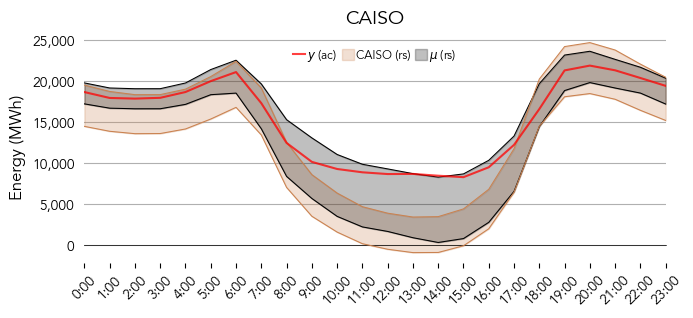

61649.3532 61649.353200000005


In [340]:
i_zone   = 3
i_sample = 10
zone     = zones_[i_zone]

l_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
s_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
w_zones_idx_ = [[0], [1], [], [0, 1]][i_zone]

net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_ = _calculate_reserve_level(models_        = [_l_model, _s_model, _w_model], 
                                                                        baselines_     = [_l_baselines, _s_baselines, _w_baselines], 
                                                                        zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                                                        caiso_rs_level = 0.12, 
                                                                        i_sel_sample   = i_sample)

_plot_reserves(net_, net_caiso_, rs_caiso_, net_ml_, rs_ml_, zone, i_sample, path      = path_to_images,
                                                                             save      = True, 
                                                                             legend    = True, 
                                                                             letter    = '', 
                                                                             y_min     = -10., 
                                                                             y_max     = 5000.,
                                                                             file_name = 'res_{}_{}.png')

print(rs_caiso_.sum(), rs_ml_.sum())

70132.7916 70132.7916 3639.8183999999997 2435.9303999999997 4556.29522393795 1369.7269289374217


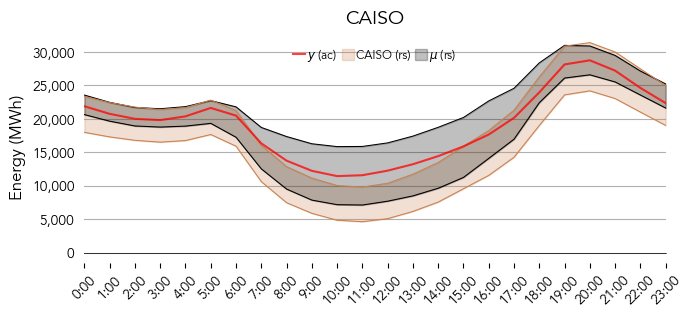

In [341]:
i_zone   = 3
i_sample = 60
zone     = zones_[i_zone]

l_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
s_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
w_zones_idx_ = [[0], [1], [], [0, 1]][i_zone]

net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_ = _calculate_reserve_level(models_        = [_l_model, _s_model, _w_model], 
                                                                        baselines_     = [_l_baselines, _s_baselines, _w_baselines], 
                                                                        zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                                                        caiso_rs_level = 0.12, 
                                                                        i_sel_sample   = i_sample)

print(rs_caiso_.sum(), rs_ml_.sum(), rs_caiso_.max(), rs_caiso_.min(), rs_ml_.max(), rs_ml_.min())
_plot_reserves(net_, net_caiso_, rs_caiso_, net_ml_, rs_ml_, zone, i_sample, path      = path_to_images,
                                                                             save      = True, 
                                                                             legend    = True, 
                                                                             letter    = '', 
                                                                             y_min     = -10., 
                                                                             y_max     = 5000.,
                                                                             file_name = 'res_{}_{}.png')

## Estimate Expected Energy Traded in Imbalance Market

In [114]:
def _plot_clearing(caiso_im_, ml_im_, zone, save   = False, 
                                                          legend = True, 
                                                          letter = '', 
                                                          y_min  = -10., 
                                                          y_max  = 5000.,
                                                          path   = '',
                                                          file_name = 'market_{}_{}.png'):
    
    x_ = np.linspace(0, caiso_im_[0].shape[0] - 1, caiso_im_[0].shape[0], dtype = int)

    fig = plt.figure(figsize = (7.5, 3.))
    ax  = plt.subplot(111)

    plt.title(f'{zone}', fontsize = 14)

    
    ax.bar(x_, ml_im_[0], color  = "k", label = 'ML',
                          alpha  = .625, 
                          zorder = 11)

    ax.bar(x_,  ml_im_[1], color  = "k", 
                           alpha  = .625, 
                           zorder = 11)

    ax.bar(x_, caiso_im_[0], color  = "#09155a", label = 'CAISO', 
                             alpha  = .625, 
                             zorder = 10)

    ax.bar(x_, caiso_im_[1], color  = "#09155a",
                             alpha  = .625, 
                             zorder = 10)
    
    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.5, 0.9),
                  frameon        = False, 
                  columnspacing = 0.4, 
                  handletextpad = .2,
                  ncol           = 11,
                  prop           = {'size': 8.5})

    ax.set_xlabel(r'Imbalance Market Interval', fontsize = 12)
    ax.set_ylabel(r'Energy Imports & Exports (MWh)', fontsize = 12)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    plt.xlim(-0.5, 23.5)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    ax.yaxis.set_tick_params(labelsize = 10, 
                             left      = False)

    plt.ylim(y_min, y_max)

    ax.text(-2.5, y_max*1.125, letter, fontsize = 20, 
                                       weight   = "bold")

    ax.axhline(0., linewidth = .5, 
                   linestyle = '-', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 9)


    if save: plt.savefig(path + file_name.format(zone), bbox_inches = 'tight', 
                                                        dpi         = 250)


    plt.show()
    
    
def _plot_market(caiso_im_, ml_im_, zone, save   = False, ylabel = r'Energy (MWh)',
                                                          legend = True, 
                                                          letter = '', 
                                                          y_min  = -10., 
                                                          y_max  = 5000.,
                                                          path   = '',
                                                          file_name = 'market_{}_{}.png'):
    
    x_ = np.linspace(0, caiso_im_.shape[0] - 1, caiso_im_.shape[0], dtype = int)

    fig = plt.figure(figsize = (7.5, 3.))
    ax  = plt.subplot(111)

    plt.title(f'{zone}', fontsize = 14)

    
    ax.bar(x_, ml_im_, color  = "k", 
                       label  = 'ML',
                       alpha  = .6, 
                       zorder = 10)

    ax.bar(x_, caiso_im_, color  = "#09155a", 
                          label  = 'CAISO',
                          alpha  = .6, 
                          zorder = 11)
    
    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.5, 0.9),
                  frameon        = False, 
                  columnspacing  = 0.4, 
                  handletextpad  = .2,
                  ncol           = 11,
                  prop           = {'size': 8.5})

    ax.set_xlabel(r'Imbalance Market Interval', fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    plt.xlim(-0.5, 23.5)
    plt.ylim(y_min, y_max)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    ax.yaxis.set_tick_params(labelsize = 10, 
                             left      = False)

    ax.text(-2.5, y_max*1.125, letter, fontsize = 20, 
                                       weight   = "bold")

    ax.axhline(0., linewidth = .5, 
                   linestyle = '-', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 9)

    if save: plt.savefig(path + file_name.format(zone), bbox_inches = 'tight', 
                                                        dpi         = 250)


    plt.show()

def _simulate_imbalance_market(models_, baselines_, caiso_rs_level, i_zone, N_samples):
    
    l_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
    s_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
    w_zones_idx_ = [[0], [1], [], [0, 1]][i_zone]

    ml_im_buy_     = np.zeros((24,))
    ml_im_sell_    = np.zeros((24,))
    caiso_im_buy_  = np.zeros((24,))
    caiso_im_sell_ = np.zeros((24,))

    for i_sample in range(N_samples):
        net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_ = _calculate_reserve_level(models_        = models_, 
                                                                                baselines_     = baselines_, 
                                                                                zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                                                                caiso_rs_level = caiso_rs_level, 
                                                                                i_sel_sample   = i_sample)
        

        ml_im_sell_p_    = np.zeros((24,))

    
        idx_                  = net_ > (net_caiso_ + rs_caiso_)
        caiso_im_buy_[idx_]  -= net_[idx_] - (net_caiso_[idx_] + rs_caiso_[idx_])
        idx_                  = net_ < (net_caiso_ - rs_caiso_)
        caiso_im_sell_[idx_] -= net_[idx_] - (net_caiso_[idx_] - rs_caiso_[idx_])

        idx_               = net_ > (net_ml_ + rs_ml_)
        ml_im_buy_[idx_]  -= net_[idx_] - (net_ml_[idx_] + rs_ml_[idx_])
        idx_               = net_ < (net_ml_ - rs_ml_)
        ml_im_sell_[idx_] -= net_[idx_] - (net_ml_[idx_] - rs_ml_[idx_])

        
    caiso_im_buy_  /= N_samples
    caiso_im_sell_ /= N_samples

    ml_im_buy_  /= N_samples
    ml_im_sell_ /= N_samples
    
    return [caiso_im_buy_, caiso_im_sell_], [ml_im_buy_, ml_im_sell_]

i_zone = 3
zone   = zones_[i_zone]

caiso_im_, ml_im_ = _simulate_imbalance_market(models_        = [_l_model, _s_model, _w_model], 
                                               baselines_     = [_l_baselines, _s_baselines, _w_baselines], 
                                               caiso_rs_level = 0.12, 
                                               i_zone         = i_zone,
                                               N_samples      = 243)

print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[0].min(), ml_im_[1].max())
print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[0].min(), caiso_im_[1].max())

-217.98020077599318 131.74048623019675 -28.065475550091538 15.373781223312378
-4903.2979681069955 0.0 -762.1908290123456 0.0


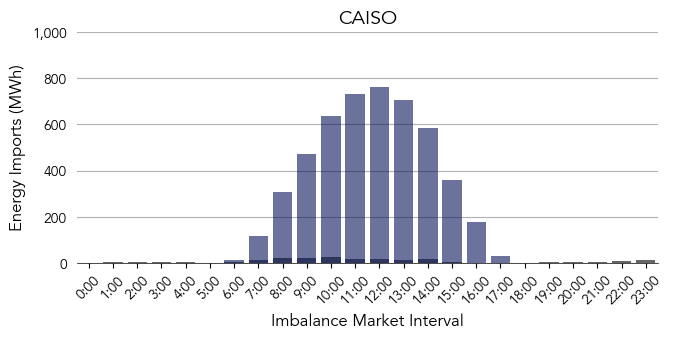

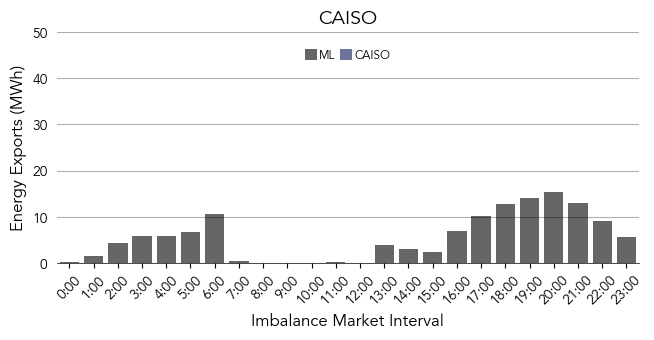

In [115]:
_plot_market(-caiso_im_[0], -ml_im_[0], zone, save      = False, 
                                              legend    = False, 
                                              ylabel    = 'Energy Imports (MWh)',
                                              y_min     = 0., 
                                              y_max     = 1000.,
                                              path      = path_to_images,
                                              file_name = 'market_buy_{}.png')
    
_plot_market(caiso_im_[1], ml_im_[1], zone, save      = False, 
                                            legend    = True, 
                                            ylabel    = 'Energy Exports (MWh)',
                                            y_min     = 0., 
                                            y_max     = 50.,
                                            path      = path_to_images,
                                            file_name = 'market_sell_{}.png')

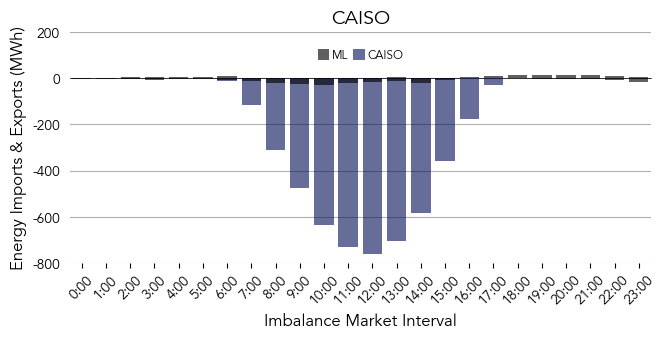

In [1063]:
_plot_clearing(caiso_im_, ml_im_, zone, save      = False, 
                                        legend    = True, 
                                        y_min     = -800., 
                                        y_max     = 200.,
                                        path      = path_to_images,
                                        file_name = 'market_{}.png')

In [1]:
def _load_model_data(model_name, path):
    
    _model = pd.read_pickle(path + model_name)
    
    meta_         = _model['targets_meta']
    meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
    meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')
    
    return _model, meta_

# Loading spatial masks
def _load_spatial_masks(i_resources_, path, map_file_name   = r"USland_0.125_(-125,-112)_(32,43).pkl",
                                            masks_file_name = r"density_grid_0.125_(-125,-112)_(32,43).pkl"):
    # Load the index of US land in the NOAA operational forecast
    US_land_ = pd.read_pickle(path + map_file_name)
    # Load the index of Demand, Solar, and Wind land in the NOAA operational forecast
    D_den_, S_den_, W_den_ = pd.read_pickle(path + masks_file_name)
    # Define spatial feature masks
    F_ = np.zeros(US_land_.shape)
    for i_resource in i_resources_:
        F_ += [D_den_, S_den_, W_den_][i_resource]
    return [np.ones(US_land_.shape), US_land_, D_den_ + S_den_ + W_den_, F_]

def _consistency_and_importance_maps(_model, M_, N_features_, i_zone, i_resource, tau = 0.):

    # Get Grid Dimensions
    N = 104
    M = 88
    
    N_features  = N_features_[i_resource]

    mask_  = M_[3]
    W_hat_ = _model['weights']
    idx_   = M_[3] > 0
    N_grid = idx_.sum()
    print(mask_.shape, W_hat_.shape, N_grid, (W_hat_ != 0.).sum())

    b_ = np.stack(W_hat_[i*N_grid:(i + 1)*N_grid] for i in range(N_features))
    b_ = np.sqrt(b_**2)
    b_norm_ = b_.copy()
    for i in range(b_norm_.shape[-1]):
        b_norm_[..., i] = b_norm_[..., i]/b_norm_[..., i].sum()
    #B_ = np.sum(b_norm_, -1)
    B_ = b_norm_[..., i_zone]

    features_ = np.zeros((N*M, N_features))
    for i in range(N_features):
        features_[idx_, i] = B_[i, :]

    features_[features_ < tau] = 0
    
    consistency_map_ = np.sum(features_ > 0., axis = 1)
    
    importance_map_ = np.sum(features_ , axis = 1)
    #importance_map_ = importance_map_/importance_map_.sum()
    features_ = features_/features_.sum()

    return features_, consistency_map_, importance_map_


# Get Grid Dimensions
N = 104
M = 88

zones_   = ['NP15', 'SP15', 'ZP26']
zones_p_ = ['PG&E', 'SCE', 'SDG&E']

_model_l, meta_l_ = _load_model_data('load-Lasso-BLR-ES.pkl', path_to_mdls)
_model_s, meta_s_ = _load_model_data('solar-Elastic_Net-GPR-LogS.pkl', path_to_mdls)
_model_w, meta_w_ = _load_model_data('wind-Elastic_Net-GPR-VS.pkl', path_to_mdls)

NameError: name 'path_to_mdls' is not defined

In [223]:
def _plot_feature_map(ax, _world, _US, _CAISO, features_, consistency_map_, W_ref_, i_resource,
                      title = '',
                      c_max    = 4., 
                      beta     = 5e-5,
                      legend   = False):

    labels_ = ['Atmospheric Pressure', 'Shortwave Irradiance', 'Longwave Irradiance', 
               'Dew Point', 'Relative Humidity', 'Temperature',
               'Wind Speed (10m)', 'Wind Speed (60m)', 'Wind Speed (80m)', 
               'Wind Speed (100m)', 'Wind Speed (120m)', 'Discomfort Index', 
               'Wind Chill', 'Heating and Cooling Degree Hours', 'Clear-Sky Irradiance']

    colors_ = ['#FF8989', '#FFE49B', '#FFD053', 
               '#FF4242', '#FF0F0F', '#C80000', 
               '#DBDEFF', '#DBDEFF', '#939DFF', 
               '#4D5EFF', '#0018FF', '#00AF1A', 
               '#6ba661', '#6ba661', '#FFB900']
        
    x_0 = -124.5
    x_1 = -112.5
    y_0 = 32.25
    y_1 = 42.25

    idx_features_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    map_features_ = [[2, 3, 4, 5, 11], [1, 2, 14], [7, 8, 9, 10]][i_resource]

    ax.set_title(title, fontsize   = 22, 
                         fontweight = "bold")
    for i in range(features_.shape[-1]):

        #idx_    = features_[:, i] > 0.001
        feature = labels_[map_features_[i]]
        color   = colors_[map_features_[i]]

            
        for j in np.argsort(features_[:, i])[::-1]:
            if features_[j, i] > 0.:
                ax.scatter(W_ref_[j, 0], W_ref_[j, 1], marker     = 'o', 
                                                       s          = 7.5*(features_[j, i]/beta)**2, 
                                                       facecolor  = 'None', 
                                                       edgecolors = color, 
                                                       lw         = 1.,
                                                       linestyle  = '-',
                                                       zorder     = 10, 
                                                       alpha      = 1., 
                                                       clip_on    = True) 

    idx_ = consistency_map_ > 0.
    
    #_cmap   = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "violet", "blue"])
    _cmap   = "plasma"
    _norm   = mpl.colors.Normalize(vmin = 1, vmax = c_max)    
    _mapper = cm.ScalarMappable(norm = _norm, cmap = _cmap)
    
    if legend:
        cbar    = plt.colorbar(_mapper, cax = fig.add_axes([0.69, 0.2, 0.01, 0.1]), ticks = [1, c_max])
        cbar.ax.set_ylabel('Consistency', rotation = 270, 
                                          labelpad = 12.5, 
                                          fontsize = 12)

    ax.scatter(W_ref_[idx_, 0], W_ref_[idx_, 1], marker     = 's', 
                                                 s          = 13.5, 
                                                 facecolor  = _mapper.to_rgba(consistency_map_[idx_]),
                                                 edgecolors = 'None', 
                                                 zorder     = 5, 
                                                 alpha      = 1.) 
    
    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 2., 
                                 edgecolor = 'none', 
                                 color     = 'k', 
                                 alpha     = .3,
                                 #color     = 'None', 
                                 zorder    = 2)

    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 2., 
                                 edgecolor = 'w', 
                                 alpha     = 1.,
                                 color     = 'None', 
                                 zorder    = 3)
    
    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = .75, 
                                    edgecolor = 'None', 
                                    color     = 'k', 
                                    #color     = 'None', 
                                    alpha     = .4, 
                                    zorder    = 2)
    
    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = .75, 
                                    edgecolor = 'w', 
                                    color     = 'None', 
                                    alpha     = 1., 
                                    zorder    = 3)

    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'None', 
                                                                color     = 'k', 
                                                                #color     = 'None', 
                                                                alpha     = .1, 
                                                                zorder    = 1)
    
    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'w', 
                                                                color     = 'None', 
                                                                alpha     = 1., 
                                                                zorder    = 1)
    if legend:
        legend_0_ = []
        for weight, weight_label in zip([1.25, 5., 17, 6.25], [0.5, 1, 2]):
 
            legend_0_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = weight, 
                                              markeredgecolor = 'k',
                                              markeredgewidth = .5,
                                              color           = "None",
                                              label           = f'{weight_label}%',
                                              markerfacecolor = "None"))

        _leg_0 = ax.legend(handles        = legend_0_, 
                           title          = r'Importance', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (.63, 1.025),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 9.5, 
                           title_fontsize = 12)

        ax.add_artist(_leg_0)
        
        legend_1_ = []
        for feature_label, color in zip([labels_[i] for i in map_features_], [colors_[i] for i in map_features_]):
 
            legend_1_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = 10, 
                                              markeredgecolor = color,
                                              markeredgewidth = .5,
                                              color           = "None",
                                              label           = '{}'.format(feature_label),
                                              markerfacecolor = "None"))

        _leg_1 = ax.legend(handles        = legend_1_, 
                           title          = r'Feature', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (1.03, 1.025),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 9.5, 
                           title_fontsize = 12)

        ax.add_artist(_leg_1)
        
    ax.set_xlabel('Longitude', fontsize = 14)
    ax.set_ylabel('Latitude',  fontsize = 14)

    ax.set_xlim(x_0, x_1)
    ax.set_ylim(y_0, y_1)

    ax.axis('off')

(9152,) (9152,) (9152,) (9152,)
(9152,) (4415, 3) 883 462


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(9152,) (4415, 3) 883 462


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(9152,) (4415, 3) 883 462


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


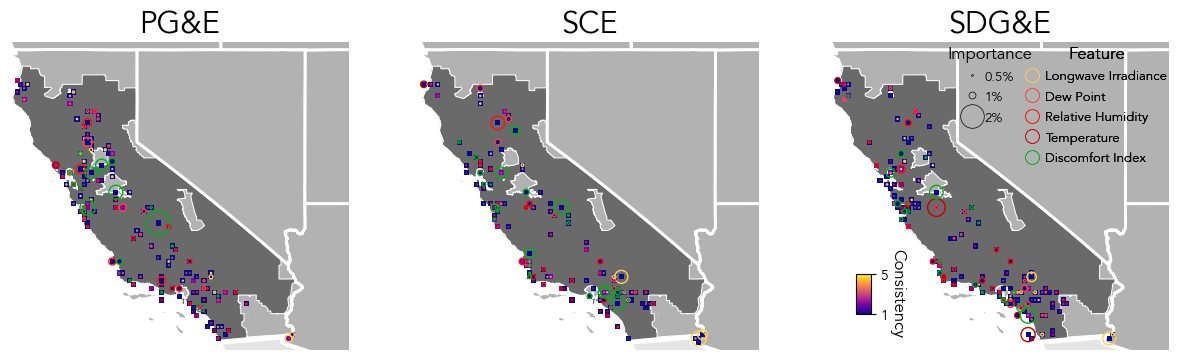

In [224]:
fig, (_ax1, _ax2, _ax3) = plt.subplots(1, 3, figsize = (15, 4), 
                                             squeeze = True)

i_resource = 0

# Loading spatial masks
M_ = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
print(M_[0].shape, M_[1].shape, M_[2].shape, M_[3].shape)

i_zone = 0
zone   = zones_p_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax1, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = False)

i_zone = 1
zone   = zones_p_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax2, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = False)

i_zone = 2
zone   = zones_p_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax3, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = True)

plt.savefig(path_to_images + 'features_map_load_ES.pdf', bbox_inches = 'tight',
                                                         dpi         = 300)
        
plt.show()

(9152,) (9152,) (9152,) (9152,)
(9152,) (3996, 3) 1332 356


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(9152,) (3996, 3) 1332 356


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(9152,) (3996, 3) 1332 356


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


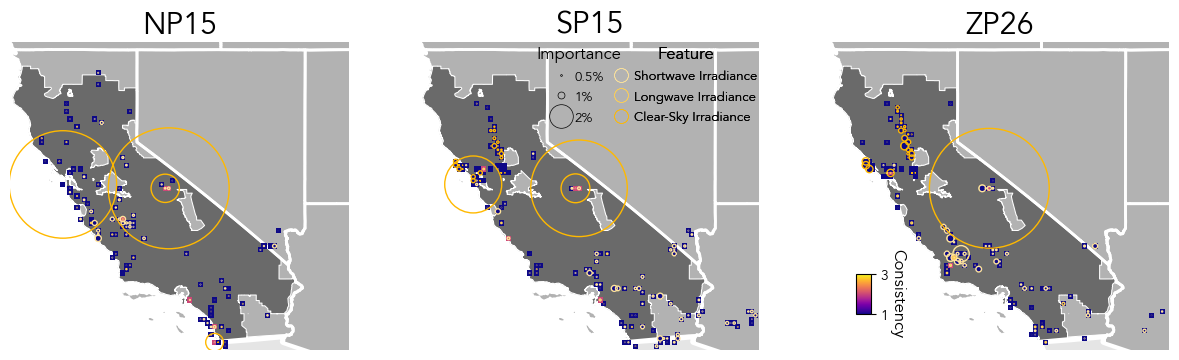

In [218]:
fig, (_ax1, _ax2, _ax3) = plt.subplots(1, 3, figsize = (15, 4), 
                                             squeeze = True)

i_resource = 1

# Loading spatial masks
M_ = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
print(M_[0].shape, M_[1].shape, M_[2].shape, M_[3].shape)

i_zone = 0
zone   = zones_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax1, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = False)

i_zone = 1
zone   = zones_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax2, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = True)

i_zone = 2
zone   = zones_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax3, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = False)


plt.savefig(path_to_images + 'features_map_solar_LogS.pdf', bbox_inches = 'tight',
                                                            dpi         = 300)
        
plt.show()

(9152,) (9152,) (9152,) (9152,)
(9152,) (1068, 2) 267 626


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(9152,) (1068, 2) 267 626


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


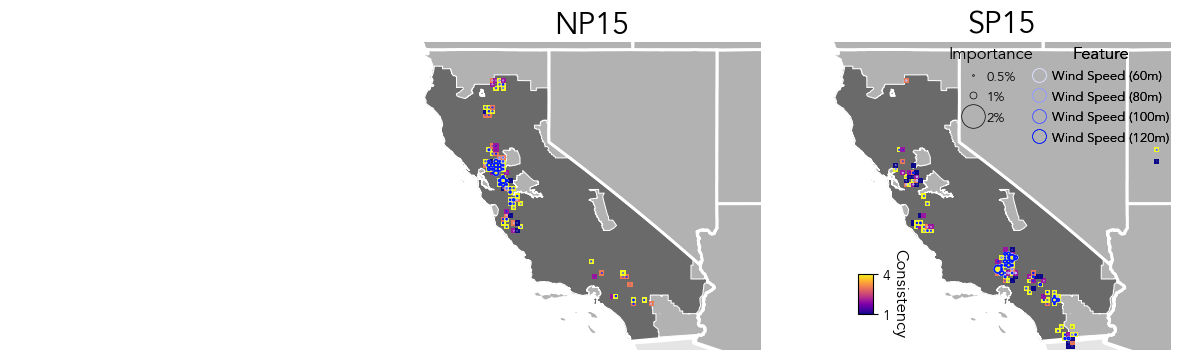

In [202]:
fig, (_ax1, _ax2, _ax3) = plt.subplots(1, 3, figsize = (15, 4), 
                                             squeeze = True)

i_resource = 2

# Loading spatial masks
M_ = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
print(M_[0].shape, M_[1].shape, M_[2].shape, M_[3].shape)

_ax1.axis('off')

i_zone = 0
zone   = zones_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax2, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = False)

i_zone = 1
zone   = zones_[i_zone]

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_l, _model_s, _model_w][i_resource], 
                                                                                M_, [5, 3, 4], i_zone, i_resource)

_plot_feature_map(_ax3, _world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_resource,
                  c_max    = features_.shape[-1],
                  title    = zone,
                  beta     = .01,
                  legend   = True)


plt.savefig(path_to_images + 'features_map_wind_VS.pdf', bbox_inches = 'tight',
                                                         dpi         = 300)
        
plt.show()